# Importing the Dataset


In [ ]:
# ============================================================
# BLOCK A0 — LOADING AND DESCRIPTION OF THE COMPLETE DATASET (396)
# ------------------------------------------------------------
# Objective:
#   - Load the 396 architectures (all classes).
#   - Verify the format of the 'services' column (lists per row).
#   - Build 'transactions_all' = list of lists containing the services.
#   - Compute and display descriptive statistics:
#       (1) Count by class (tipo_arquitectura)
#       (2) Size statistics (# of services per architecture)
#       (3) Service universe (number of unique services)
#       (4) Top-15 services by prevalence (% of architectures where they appear)
#   - These results are included in the Data/Methodology section of the paper.
# ============================================================

import pandas as pd
from collections import Counter

# ---------- 1) Load ----------
PKL_PATH = "arquitecturas_etiquetadas.pkl"
df_all = pd.read_pickle(PKL_PATH)

print("File loaded:", PKL_PATH)
print("Total rows (expected ≈396):", len(df_all))
print("Available columns:", df_all.columns.tolist())

# ---------- 2) Validate format ----------
# Ensure that 'services' is a list in every row
if not df_all["services"].apply(lambda x: isinstance(x, list)).all():
    raise TypeError("The 'services' column must contain lists of strings per row.")

# ---------- 3) Build transactions ----------
transactions_all = df_all["services"].tolist()

# ---------- 4) Count by class ----------
print("\n=== Class distribution (tipo_arquitectura) ===")
if "tipo_arquitectura" in df_all.columns:
    vc = df_all["tipo_arquitectura"].value_counts(dropna=False)
    print(vc.to_string())
else:
    print("Column 'tipo_arquitectura' is not available in this file.")

# ---------- 5) Size statistics (# of services per architecture) ----------
sizes = pd.Series([len(set(tx)) for tx in transactions_all], name="size")
desc = sizes.describe(percentiles=[0.25, 0.5, 0.75]).round(3)

print("\n=== Architecture size (# of distinct services) ===")
print(desc.to_string())
print(f"Coefficient of variation (std/mean): {(desc['std']/desc['mean']):.3f}")

# ---------- 6) Service universe (unique services in the entire dataset) ----------
unique_services = sorted(set().union(*[set(tx) for tx in transactions_all]))
print("\n=== Service universe ===")
print("Number of unique services in the dataset:", len(unique_services))

# ---------- 7) Top-15 services by prevalence ----------
service_in_arch_count = Counter()
for tx in transactions_all:
    for s in set(tx):
        service_in_arch_count[s] += 1

total_arch = len(transactions_all)
top15 = service_in_arch_count.most_common(15)

print("\n=== Top-15 services by prevalence ===")
for s, c in top15:
    pct = 100.0 * c / total_arch
    print(f"{s:25s}  {c:3d} / {total_arch}  ({pct:5.1f}%)")

# ---------- 8) Sample view (for traceability in the paper) ----------
print("\n=== Sample of architectures (first 10 rows) ===")
display(df_all.head(10)[['architecture','services','tipo_arquitectura']])


Archivo cargado: arquitecturas_etiquetadas.pkl
Filas totales (esperado ≈396): 396
Columnas disponibles: ['architecture', 'services', 'tipo_arquitectura']

=== Distribución por clase (tipo_arquitectura) ===
tipo_arquitectura
None        280
Edge        101
HPC          10
Edge+HPC      5

=== Tamaño de arquitecturas (# servicios distintos) ===
count    396.000
mean       7.447
std        2.165
min        1.000
25%        6.000
50%        7.500
75%        9.000
max       14.000
Coeficiente de variación (std/mean): 0.291

=== Universo de servicios ===
N° de servicios únicos en la base: 169

=== Top-15 servicios por prevalencia ===
S3                         253 / 396  ( 63.9%)
Lambda                     220 / 396  ( 55.6%)
ThirdParty                 154 / 396  ( 38.9%)
EC2                        152 / 396  ( 38.4%)
DynamoDB                   123 / 396  ( 31.1%)
ApiGateway                  96 / 396  ( 24.2%)
UserConsumerWeb             87 / 396  ( 22.0%)
RDS                         79 / 39

,architecture,services,tipo_arquitectura
0,7LziNjUTo7w,"[Lambda, CloudFormation, UserConsumerWeb, AppS...",HPC
1,c-1GXhOOOww,"[Lambda, ApiGateway, DynamoDB, ThirdParty, S3,...",None
2,asZIXK7V-U4,"[Lambda, Athena, ApiGateway, SageMaker, UserCo...",None
3,RU__HBEMDvQ,"[SageMaker, UserCompanyDataStream, S3, StepFun...",None
4,KywvGM6HVXI,"[Lambda, DynamoDB, ApiGateway, UserConsumerWeb...",None
5,CDCLwX2fo2g,"[DynamoDB, ALB, EC2, S3, ECS, UserConsumerMobi...",None
6,hbz63Ve-eIY,"[Lambda, DynamoDB, S3, CloudWatch, UserCompany...",None
7,mmM_JnYygZM,"[ApiGateway, UserConsumerWeb, UserCompanyDataS...",Edge
8,cmlhEbm1kPk,"[Lambda, DynamoDB, S3, Polly, Lex, MediaConnec...",None
9,gD8pzUnXgsU,"[CloudFormation, ThirdParty, S3, OnPremDC, Clo...",None


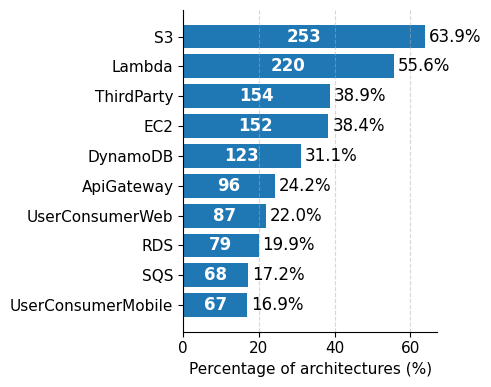

In [ ]:
# ============================================================
# EPS Plot: Top-10 services by PREVALENCE (all 396)
# ------------------------------------------------------------
# Prerequisites:
#   - df_all already loaded with columns: ['architecture','services', 'tipo_arquitectura']
#     (if you prefer, uncomment the PKL loading line).
# Output:
#   - EPS file: fig_top_services_overall.eps
# ============================================================

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# --- (Optional) Load if df_all is not in memory ---
# df_all = pd.read_pickle("arquitecturas_etiquetadas.pkl")

# --- Minimal validation ---
assert {'architecture','services'}.issubset(df_all.columns), \
       "df_all debe tener columnas ['architecture','services']"

# --- Global style (matched to your example) ---
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11
})

def export_eps(fig, filename):
    """Exporta la figura a EPS con bounding box ajustado."""
    fig.savefig(filename, format="eps", bbox_inches="tight")

def plot_top_services_overall(df, top_n=10, filename="fig_top_services_overall.eps"):
    """
    Plots Top-N services by PREVALENCE in the full dataset.
    Prevalence = # of architectures that include the service / total architectures.
    """
    # 1) Build transactions (a list of services per architecture)
    transactions_all = df['services'].tolist()
    total_archs = len(transactions_all)

    # 2) Count PREVALENCE (presence at least once per architecture)
    service_in_arch_count = Counter()
    for tx in transactions_all:
        for s in set(tx):                 # set() avoids duplicates within the SAME architecture
            service_in_arch_count[s] += 1

    # 3) Top-N by prevalence
    top_items = service_in_arch_count.most_common(top_n)
    df_top = pd.DataFrame(top_items, columns=["Service", "Count"])
    df_top["Percentage"] = (df_top["Count"] / total_archs) * 100

    # 4) Horizontal bar chart
    fig, ax = plt.subplots(figsize=(5, 4))
    bars = ax.barh(df_top["Service"], df_top["Percentage"])   # default color (consistent with example)

    # 5) Annotations: absolute value inside + percentage to the right
    for bar, pct, n_abs in zip(bars, df_top["Percentage"], df_top["Count"]):
        # absolute number centered, in white over the bar
        ax.text(bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{n_abs}",
                ha='center', va='center',
                color='white',
                fontsize=12, fontweight='semibold')

        # percentage to the right of the bar
        ax.text(bar.get_width() + 1,
                bar.get_y() + bar.get_height()/2,
                f"{pct:.1f}%",
                ha='left', va='center',
                fontsize=12)

    # 6) Aesthetics and axes
    ax.set_xlabel("Percentage of architectures (%)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.yaxis.grid(False)
    ax.invert_yaxis()  # most prevalent on top
    plt.tight_layout()

    # 7) Export to EPS
    export_eps(fig, filename)
    plt.show()


plot_top_services_overall(df_all, top_n=10, filename="fig_top_services_overall.eps")


Prevalence measures how many architectures a service appears in at least once, divided by the total number of architectures. In other words, it's a relative frequency at the architecture level, not at the level of individual occurrences.

This is more useful here because we want to know which services characterize the architectures (e.g., "2 out of 3 architectures use S3"), rather than how many times it appears in the same row.

#Block A1: Itemset and rule mining (FP-Growth) over the 396.



In [ ]:
# ============================================================
# BLOCK A1 — FP-GROWTH ON THE COMPLETE DATASET (396)
# ------------------------------------------------------------
# Objective:
#   - Extract service co-occurrence patterns using FP-Growth.
#   - Generate association rules X -> Y (confidence, lift) in two modes:
#       * min_support = 0.06  → more conservative (robust patterns)
#       * min_support = 0.03  → more diverse (less frequent patterns)
#   - Produce a clear summary for validation (# of itemsets and rules) and
#     display a sample of rules sorted by strength.
# Requirements:
#   - df_all in memory, with column 'services' (lists per row).
#   - mlxtend package installed (if not, pip install mlxtend).
# Outputs:
#   - fis_all_006, rules_all_006  (itemsets/rules for 0.06)
#   - fis_all_003, rules_all_003  (itemsets/rules for 0.03)
#   - (Optional) CSVs with rules for paper auditing.
# ============================================================

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# ---------- Minimal validations ----------
assert 'services' in df_all.columns, "df_all debe tener la columna 'services' (listas por fila)."
assert df_all['services'].apply(lambda x: isinstance(x, list)).all(), \
       "La columna 'services' debe contener listas de strings por fila."

def mine_rules_fp_growth(transactions, min_support, min_confidence=0.60, min_lift=1.05):
    """
    Extrae itemsets frecuentes y reglas de asociación para un soporte dado.
    - transactions: lista de listas de servicios.
    - min_support: umbral mínimo de soporte (proporción de arquitecturas).
    - min_confidence: P(Y|X) mínima para reglas X->Y.
    - min_lift: lift > 1.0 asegura que la asociación no sea debida al azar.
    Devuelve: (frequent_itemsets_df, rules_df)
    """
    # 1) One-hot encoding of transactions
    te = TransactionEncoder()
    basket = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(basket, columns=te.columns_).astype('uint8')

    # 2) Frequent itemsets via FP-Growth
    frequent_itemsets = fpgrowth(df_basket, min_support=min_support, use_colnames=True)

    # 3) Association rules (filtered by confidence and lift)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    rules = rules[rules['lift'] > min_lift].copy()

    # 4) Sort rules by strength (confidence first, then lift and support)
    rules.sort_values(['confidence','lift','support'], ascending=False, inplace=True)
    rules.reset_index(drop=True, inplace=True)

    return frequent_itemsets, rules

# ---------- Run for both supports ----------
transactions_all = df_all['services'].tolist()

fis_all_006, rules_all_006 = mine_rules_fp_growth(
    transactions_all, min_support=0.06, min_confidence=0.60, min_lift=1.05
)
fis_all_003, rules_all_003 = mine_rules_fp_growth(
    transactions_all, min_support=0.03, min_confidence=0.60, min_lift=1.05
)

# ---------- Notebook validation summary ----------
print("=== FP-Growth summary (complete dataset) ===")
print(f"[0.06] Itemsets: {len(fis_all_006):4d} | Rules: {len(rules_all_006):4d}")
print(f"[0.03] Itemsets: {len(fis_all_003):4d} | Rules: {len(rules_all_003):4d}")

print("\n=== Sample of rules (0.06) — top 10 by confidence/lift ===")
display(rules_all_006[['antecedents','consequents','support','confidence','lift']].head(10))

print("\n=== Sample of rules (0.03) — top 10 by confidence/lift ===")
display(rules_all_003[['antecedents','consequents','support','confidence','lift']].head(10))



rules_all_006.to_csv("rules_all_support006.csv", index=False)
rules_all_003.to_csv("rules_all_support003.csv", index=False)
print("Saved: rules_all_support006.csv | rules_all_support003.csv")


=== Resumen FP-Growth (conjunto completo) ===
[0.06] Itemsets:  118 | Reglas:   53
[0.03] Itemsets:  345 | Reglas:  169

=== Muestra de reglas (0.06) — top 10 por confianza/lift ===


,antecedents,consequents,support,confidence,lift
0,(Glue),(S3),0.098485,1.000000,1.565217
1,(Firehose),(S3),0.075758,1.000000,1.565217
2,(EMR),(S3),0.068182,1.000000,1.565217
3,"(Firehose, Lambda)",(S3),0.060606,1.000000,1.565217
4,(Athena),(S3),0.113636,0.978261,1.531191
5,(RedShift),(S3),0.080808,0.969697,1.517787
6,"(Athena, Lambda)",(S3),0.073232,0.966667,1.513043
7,"(ApiGateway, DynamoDB, S3)",(Lambda),0.063131,0.925926,1.666667
8,"(SageMaker, Lambda)",(S3),0.060606,0.888889,1.391304
9,"(ApiGateway, DynamoDB)",(Lambda),0.098485,0.886364,1.595455



=== Muestra de reglas (0.03) — top 10 por confianza/lift ===


,antecedents,consequents,support,confidence,lift
0,"(ApiGateway, SNS)",(Lambda),0.035354,1.0,1.800000
1,"(ApiGateway, UserConsumerMobile, S3)",(Lambda),0.030303,1.0,1.800000
2,"(ApiGateway, Athena)",(Lambda),0.030303,1.0,1.800000
3,(Glue),(S3),0.098485,1.0,1.565217
4,(Firehose),(S3),0.075758,1.0,1.565217
5,(EMR),(S3),0.068182,1.0,1.565217
6,"(Firehose, Lambda)",(S3),0.060606,1.0,1.565217
7,"(Glue, Lambda)",(S3),0.055556,1.0,1.565217
8,"(Glue, Athena)",(S3),0.053030,1.0,1.565217
9,"(Athena, ThirdParty)",(S3),0.047980,1.0,1.565217


Guardados: rules_all_support006.csv | rules_all_support003.csv


Tenemos los dos catálogos de reglas (0.06 y 0.03), pasamos al siguiente bloque

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Block A2 — GENERAL ARCHITECTURE GENERATOR

This block implements a stochastic generator of distributed architectures. Given a service seed, it applies association rules derived from FP-Growth (Block A1) to expand the architecture with plausible services, until it reaches a maximum size.

In [ ]:
# ============================================================
# BLOCK A2 — GENERAL ARCHITECTURE GENERATOR
# ------------------------------------------------------------
# Objective:
#   - Starting from an initial service seed, generate
#     plausible distributed architectures.
#   - The generator applies association rules (confidence, lift)
#     and a fallback using frequent itemsets.
#   - You can use rules with support 0.06 (robust) or 0.03 (diverse).
# Requirements:
#   - Run Block A1 first → fis_all_006, rules_all_006,
#     fis_all_003, rules_all_003.
# ============================================================

import random

def generate_architecture(seed, rules_df, frequent_itemsets,
                          max_size=12, n_candidates=100, random_state=None):
    """
    Genera una arquitectura sintética a partir de una semilla.

    Parámetros:
    - seed: lista inicial de servicios (ej. ['Lambda']).
    - rules_df: DataFrame con reglas de asociación (soporte, confianza, lift).
    - frequent_itemsets: itemsets frecuentes del mismo soporte.
    - max_size: tamaño máximo de la arquitectura (nº de servicios).
    - n_candidates: número de intentos de expansión (controla diversidad).
    - random_state: semilla aleatoria para reproducibilidad.

    Retorna:
    - conjunto final de servicios (list).
    """
    if random_state is not None:
        random.seed(random_state)

    current = set(seed)

    for _ in range(n_candidates):
        if len(current) >= max_size:
            break

        # 1) Find applicable rules (antecedent ⊆ current)
        applicable = rules_df[rules_df['antecedents'].apply(lambda x: x.issubset(current))]

        # 2) If there are rules, choose a weighted consequent
        if not applicable.empty:
            # weight = confidence × log2(lift) × support
            applicable = applicable.copy()
            applicable['weight'] = (applicable['confidence'] *
                                    (applicable['lift']).apply(lambda l: max(0.01, l)).map(lambda l: math.log2(l)) *
                                    applicable['support'])
            row = random.choices(applicable.index,
                                 weights=applicable['weight'], k=1)[0]
            consequents = list(applicable.loc[row, 'consequents'])
            chosen = random.choice(consequents)
        else:
            # 3) Fallback: pick a random item from frequent itemsets
            candidates = [i for s in frequent_itemsets['itemsets'] for i in s]
            chosen = random.choice(candidates)

        current.add(chosen)

    return sorted(current)

# ============================================================
# GENERATOR USAGE EXAMPLE
# ============================================================

import math

# Example seeds
seeds = [
    ["Lambda"],
    ["S3"],
    ["IoTCore"],
    ["ApiGateway","IoTCore"],
    ["EC2"],
    ["DynamoDB"],
    ["RDS"],
    ["SQS"],
    ["EKS"],
    ["ECS"],
    ["SageMaker"],
    ["CloudWatch"],
    ["Aurora"],
    ["Batch"],
    ["CloudFront"],
    ["Greengrass"],
    ["StorageGateway"],
    ["LambdaAtEdge"],
    ["S3,RDS"],
    ["Batch,SageMaker"],

]

print("=== Generation with min_support=0.06 (robust) ===")
for seed in seeds:
    arch = generate_architecture(seed, rules_all_006, fis_all_006,
                                 max_size=8, n_candidates=30, random_state=42)
    print(f"Seed {seed} -> {arch}")

print("\n=== Generation with min_support=0.03 (diverse) ===")
for seed in seeds:
    arch = generate_architecture(seed, rules_all_003, fis_all_003,
                                 max_size=8, n_candidates=30, random_state=42)
    print(f"Seed {seed} -> {arch}")


=== Generación con min_support=0.06 (robusto) ===
Seed ['Lambda'] -> ['Lambda', 'S3']
Seed ['S3'] -> ['Lambda', 'S3']
Seed ['IoTCore'] -> ['IoTCore', 'Lambda', 'S3']
Seed ['ApiGateway', 'IoTCore'] -> ['ApiGateway', 'IoTCore', 'Lambda', 'S3']
Seed ['EC2'] -> ['EC2', 'Lambda', 'S3']
Seed ['DynamoDB'] -> ['DynamoDB', 'Lambda', 'S3']
Seed ['RDS'] -> ['RDS', 'S3']
Seed ['SQS'] -> ['Lambda', 'S3', 'SQS']
Seed ['EKS'] -> ['EKS', 'Lambda', 'S3']
Seed ['ECS'] -> ['ECS', 'Lambda', 'S3']
Seed ['SageMaker'] -> ['Lambda', 'S3', 'SageMaker']
Seed ['CloudWatch'] -> ['CloudWatch', 'Lambda', 'S3']
Seed ['Aurora'] -> ['Aurora', 'Lambda', 'S3']
Seed ['Batch'] -> ['Batch', 'Lambda', 'S3']
Seed ['CloudFront'] -> ['CloudFront', 'S3']
Seed ['Greengrass'] -> ['Greengrass', 'Lambda', 'S3']
Seed ['StorageGateway'] -> ['Lambda', 'S3', 'StorageGateway']
Seed ['LambdaAtEdge'] -> ['Lambda', 'LambdaAtEdge', 'S3']
Seed ['S3,RDS'] -> ['Lambda', 'S3', 'S3,RDS']
Seed ['Batch,SageMaker'] -> ['Batch,SageMaker', 'Lambda', 

#Block A3: Rapid evaluation of generated architectures

This first block is a short evaluation, before making a general one, it aims to have a first look at the metrics

In [ ]:
# ============================================================
# BLOCK A3 (part 1) — Bootstrap .632: 1 replicate + initial validation
# ------------------------------------------------------------
# Objective:
#   - Perform ONE stratified bootstrap replicate (≈63% train, ≈37% OOB).
#   - Mine catalogs (FP-Growth) ONLY on bootstrap (two supports: 0.06 and 0.03).
#   - Generate |OOB| architectures using each catalog (configs '006' and '003').
#   - Validate ONLY size (#services) between OOB and generated:
#       * KS-test (distance D and p-value)
#       * Wasserstein (Earth Mover’s distance)
# Requirements:
#   - df_all in memory with columns ['services','tipo_arquitectura'] (from A0).
#   - Function generate_architecture(seed, rules_df, frequent_itemsets, ...)
#     defined in A2. If it is not defined, a minimal version is activated.
#   - mlxtend installed (fpgrowth/association_rules).
# Output:
#   - Summary prints: set sizes, KS/Wasserstein per configuration.
# ============================================================

import numpy as np
import pandas as pd
import random, math
from collections import Counter
from sklearn.utils import resample
from scipy.stats import ks_2samp, wasserstein_distance
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# ---------- 0) Basic utilities ----------

def _sizes_from_transactions(transactions):
    """Devuelve lista con el # de servicios únicos por arquitectura."""
    return [len(set(tx)) for tx in transactions]

def stratified_bootstrap(df, label_col='tipo_arquitectura', random_state=123):
    """
    Bootstrap estratificado (.632):
      - Remuestrea con reemplazo DENTRO de cada clase, manteniendo proporciones.
      - Devuelve df_boot (train bootstrap) y df_oob (out-of-bag no visto).
    """
    rng = np.random.RandomState(random_state)
    parts = []
    for clase, sub in df.groupby(label_col, dropna=False):
        # resample with replacement the same size within each stratum
        idx_boot = resample(
            sub.index, replace=True, n_samples=len(sub), random_state=rng
        )
        parts.append(df.loc[idx_boot])
    df_boot = pd.concat(parts, axis=0)

    # OOB: rows from the original that do NOT appear in bootstrap (as unique indices)
    used = set(df_boot.index.unique())
    all_idx = set(df.index)
    oob_idx = sorted(list(all_idx - used))
    df_oob = df.loc[oob_idx].copy()

    return df_boot.reset_index(drop=True), df_oob.reset_index(drop=True)

def mine_catalogs(transactions, supports=(0.06, 0.03), conf_min=0.60, lift_min=1.05):
    """
    One-hot + FP-Growth for each support. Returns a dictionary:
      catalogs[0.06] = (frequent_itemsets_df, rules_df)
      catalogs[0.03] = (frequent_itemsets_df, rules_df)
    """
    te = TransactionEncoder()
    basket = te.fit(transactions).transform(transactions)
    df_basket = pd.DataFrame(basket, columns=te.columns_).astype('uint8')

    catalogs = {}
    for s in supports:
        fis = fpgrowth(df_basket, min_support=s, use_colnames=True)
        rules = association_rules(fis, metric="confidence", min_threshold=conf_min)
        rules = rules[rules['lift'] > lift_min].copy()
        rules.sort_values(['confidence','lift','support'], ascending=False, inplace=True)
        rules.reset_index(drop=True, inplace=True)
        catalogs[round(s, 2)] = (fis, rules)
    return catalogs

def select_seeds(df_boot, k, mix_ratio=0.5, random_state=123):
    """
    Choose k seeds for generation:
      - mix_ratio * k: from the Top-10 most prevalent services in df_boot (one per seed)
      - (1 - mix_ratio) * k: samples of real bootstrap architectures (one row -> its first service)
    Provides simple and reproducible traceability.
    """
    rng = np.random.RandomState(random_state)
    tx_boot = df_boot['services'].tolist()
    # prevalences in bootstrap
    c = Counter()
    for tx in tx_boot:
        for s in set(tx):
            c[s] += 1
    top10 = [s for s,_ in c.most_common(10)] or ['S3']

    n_top = int(round(k * mix_ratio))
    n_real = k - n_top

    seeds = []
    # unit seeds from top services
    for _ in range(n_top):
        seeds.append([rng.choice(top10)])
    # seeds from real bootstrap architectures (take 1–2 random services from the row)
    if len(df_boot) > 0:
        idxs = rng.choice(len(df_boot), size=n_real, replace=True)
        for i in idxs:
            row = df_boot.iloc[i]
            if len(row['services']) == 0:
                seeds.append(['S3'])
            else:
                s_pick = rng.choice(row['services'], size=min(2, len(row['services'])), replace=False).tolist()
                seeds.append(s_pick)
    return seeds

# ---------- 0-bis) Fallback: minimal generator (if A2 is not in memory) ----------
if 'generate_architecture' not in globals():
    def generate_architecture(seed, rules_df, frequent_itemsets,
                              max_size=10, n_candidates=40, random_state=None):
        """Versión mínima del generador de A2 (mismo criterio de pesos)."""
        if random_state is not None:
            random.seed(random_state)
        cur = set(seed)
        for _ in range(n_candidates):
            if len(cur) >= max_size:
                break
            applicable = rules_df[rules_df['antecedents'].apply(lambda x: x.issubset(cur))]
            if not applicable.empty:
                tmp = applicable.copy()
                tmp['weight'] = tmp['confidence'] * tmp['support'] * tmp['lift'].map(lambda l: max(1e-6, math.log2(l)))
                idx = random.choices(tmp.index, weights=tmp['weight'], k=1)[0]
                cons = list(tmp.loc[idx, 'consequents'])
                choice = random.choice(cons)
            else:
                # simple fallback: sample items from frequent itemsets
                pool = [i for s in frequent_itemsets['itemsets'] for i in s]
                if not pool: break
                choice = random.choice(pool)
            cur.add(choice)
        return sorted(cur)

# ---------- 1) Bootstrap 1 replicate ----------

df_boot, df_oob = stratified_bootstrap(df_all, label_col='tipo_arquitectura', random_state=2025)

print("=== Bootstrap .632 — 1 replicate ===")
print("Total size:", len(df_all))
print("Train bootstrap (≈63% unique + repeated):", len(df_boot))
print("OOB (unseen):", len(df_oob))
print("Class distribution in OOB:")
print(df_oob['tipo_arquitectura'].value_counts(dropna=False).to_string())

# ---------- 2) Mining ONLY on bootstrap ----------

tx_boot = df_boot['services'].tolist()
catalogs = mine_catalogs(tx_boot, supports=(0.06, 0.03), conf_min=0.60, lift_min=1.05)

for s, (fis, rules) in catalogs.items():
    print(f"\nCatalog support={s:.2f}  -> itemsets={len(fis)} | rules={len(rules)}")
    print(rules[['antecedents','consequents','support','confidence','lift']].head(3))

# ---------- 3) Generation (two configurations) ----------

N_target = len(df_oob)                             # generate as many as OOB
seeds = select_seeds(df_boot, k=N_target, mix_ratio=0.5, random_state=2025)

def generate_batch(config_key):
    fis, rules = catalogs[0.06] if config_key=='006' else catalogs[0.03]
    gens = []
    for i in range(N_target):
        seed = seeds[i]
        arch = generate_architecture(seed, rules, fis,
                                     max_size=10, n_candidates=100, random_state=2025+i)
        if arch:
            gens.append(arch)
    return gens

gen_006 = generate_batch('006')
gen_003 = generate_batch('003')

print(f"\nGenerated (006): {len(gen_006)} | Generated (003): {len(gen_003)} | OOB: {N_target}")

# ---------- 4) Initial validation: size (#services) ----------

tx_oob = df_oob['services'].tolist()

def eval_size_metrics(real_tx, gen_tx, label):
    real_sizes = _sizes_from_transactions(real_tx)
    gen_sizes  = _sizes_from_transactions(gen_tx)
    ks = ks_2samp(real_sizes, gen_sizes, alternative='two-sided', mode='auto')
    wd = wasserstein_distance(real_sizes, gen_sizes)
    print(f"\n— {label} —")
    print(f"  KS D = {ks.statistic:.4f}  |  p-value = {ks.pvalue:.4g}")
    print(f"  Wasserstein = {wd:.4f}")
    print(f"  Real (mean±std) = {np.mean(real_sizes):.2f}±{np.std(real_sizes):.2f} | "
          f"Gen (mean±std) = {np.mean(gen_sizes):.2f}±{np.std(gen_sizes):.2f}")

eval_size_metrics(tx_oob, gen_006, "Comparación de tamaños OOB vs Generadas [soporte 0.06]")
eval_size_metrics(tx_oob, gen_003, "Comparación de tamaños OOB vs Generadas [soporte 0.03]")

# (Optional) save seeds and first examples for paper traceability:
#pd.DataFrame({'seed': ['|'.join(s) for s in seeds],
#             'gen_006': ['|'.join(g) for g in gen_006[:10]],
#              'gen_003': ['|'.join(g) for g in gen_003[:10]]}).to_csv("trace_bootstrap_replica1.csv", index=False)


=== Bootstrap .632 — 1 réplica ===
Tamaño total: 396
Train bootstrap (≈63% únicas + repetidas): 396
OOB (no visto): 148
Distribución por clase en OOB:
tipo_arquitectura
None        107
Edge         35
HPC           4
Edge+HPC      2

Catálogo soporte=0.06  -> itemsets=117 | reglas=46
  antecedents consequents   support  confidence      lift
0    (Athena)        (S3)  0.093434         1.0  1.596774
1      (Glue)        (S3)  0.083333         1.0  1.596774
2  (RedShift)        (S3)  0.068182         1.0  1.596774

Catálogo soporte=0.03  -> itemsets=338 | reglas=176
  antecedents consequents   support  confidence      lift
0    (Athena)        (S3)  0.093434         1.0  1.596774
1      (Glue)        (S3)  0.083333         1.0  1.596774
2  (RedShift)        (S3)  0.068182         1.0  1.596774

Generadas (006): 148 | Generadas (003): 148 | OOB: 148

— Comparación de tamaños OOB vs Generadas [soporte 0.06] —
  KS D = 0.8378  |  p-value = 4.289e-53
  Wasserstein = 4.4459
  Real (mean±std) =

#Block A3: Complete evaluation using 10-fold

Funciones principales

In [ ]:
# ============================================================
# PATCH A3 — "Size-aware" generator (align synthetic sizes to real ones)
# ------------------------------------------------------------
# Idea:
#   1) Take the architecture generated by rules (your current generate_architecture).
#   2) Set a target_size ~ real size distribution (#services) from the fold/bootstrap.
#   3) If the generated architecture is smaller, COMPLETE it with plausible services
#      sampled with probability proportional to their observed support (frequency) in train.
#      - without repeating already present services
#      - respecting an optional set of "forbidden" services
#      - with an option to require at least 1 Edge service if desired
#   4) Retry with another seed if it remains too small.
#
# Requirements:
#   - 'mine_catalogs' returns both "fis" (frequent itemsets) and "rules".
#   - fis is a DataFrame with columns: ['support','itemsets'] (mlxtend).
#   - df_train is the fold/bootstrap DF (to estimate the real size distribution).
#   - Your generate_architecture(seed, rules, fis, ...) already exists.
# ============================================================

import numpy as np
from collections import Counter

# --- (Optional) your list of services considered "Edge"
EDGE_SERVICES = set([
    "Snowball","Snowcone","Snowmobile","SnowFamily",
    "SageMakerNeo","SageMakerEdgeManager","Monitron","Panorama",
    "RoboMaker","CloudFront","Greengrass","FreeRTOS","IoTCore","IoTSiteWise",
    "AlexaForBusiness","LocalZones","Wavelength","Outpost","StorageGateway",
    "UserConsumerCamera","UserCompanyEdge","UserConsumerEdge",
    "UserConsumerIOT","UserConsumerPOS","UserCompanyDrone","UserConsumerFarmer",
    "UserConsumerAlexaGoogleHome","UserCompanyElementalLiveDevice","UserConsumerTV",
    "LambdaAtEdge"
])

def _real_size_sampler(df_train, rng, clip=(5, 11)):
    """
    Estima la distribución de tamaños reales en 'df_train' y muestrea un target_size.
    - Por defecto recorta a [5, 11] aprox. (entre P25 y P75 de tu base).
    """
    sizes = [len(set(s)) for s in df_train["services"]]
    mu, sd = float(np.mean(sizes)), max(0.8, float(np.std(sizes, ddof=1)))
    # Muestra de una Normal truncada “suave”
    for _ in range(10):
        t = int(round(rng.normal(mu, sd)))
        if clip[0] <= t <= clip[1]:
            return t
    # fallback: mediana si no entró en el rango en 10 intentos
    return int(np.median(sizes))

def _item_weights_from_fis(fis):
    """
    Deriva pesos por servicio usando los itemsets frecuentes.
    - Usamos el soporte del singleton si existe; si no, el máximo soporte
      de cualquier itemset que lo contenga (proxy razonable).
    """
    singletons = {list(it)[0]: sup for sup, it in zip(fis["support"], fis["itemsets"]) if len(it)==1}
    if singletons:
        return singletons
    # If no singletons exist in FIS, aggregate by taking the max support over itemsets containing the item
    acc = Counter()
    for sup, it in zip(fis["support"], fis["itemsets"]):
        for s in it:
            acc[s] = max(acc[s], sup)
    return dict(acc)

def _complete_with_items(current, weights, target_size, rng,
                         forbid=frozenset(), require_edge=False):
    """
    Completes 'current' up to target_size by roulette selection proportional to weights.
    - Avoids duplicates and forbidden services.
    - If require_edge=True, forces at least one service from EDGE_SERVICES.
    """
    chosen = set(current)
    pool = [s for s in weights.keys() if s not in chosen and s not in forbid]
    if not pool:
        return list(chosen)

    # probability vector proportional to weights
    w = np.array([weights[s] for s in pool], dtype=float)
    if w.sum() <= 0:
        w = np.ones_like(w)
    p = w / w.sum()

    # complete up to the target size
    while len(chosen) < target_size and len(pool) > 0:
        s = rng.choice(pool, p=p)
        chosen.add(s)
        # remove from pool
        idx = pool.index(s)
        pool.pop(idx); p = np.delete(p, idx)
        if p.sum() > 0:
            p = p / p.sum()

    # if an Edge service is required and none exists, try replacing one non-Edge with an available Edge
    if require_edge and not (EDGE_SERVICES & chosen):
        candidates = [s for s in weights.keys() if s in EDGE_SERVICES and s not in chosen and s not in forbid]
        if candidates:
            # pick the most plausible Edge by weight
            s_edge = max(candidates, key=lambda s: weights.get(s, 0))
            # replace the least-weighted non-Edge if necessary
            non_edge = [s for s in chosen if s not in EDGE_SERVICES]
            if non_edge:
                s_out = min(non_edge, key=lambda s: weights.get(s, 0))
                chosen.remove(s_out); chosen.add(s_edge)

    return list(chosen)

def generate_architecture_size_aware(seed, rules, fis, df_train,
                                     max_size=10, n_candidates=100,
                                     require_edge=False, random_state=2025):
    """
    Envoltorio "size-aware":
      1) Llama a tu 'generate_architecture' (basada en reglas).
      2) Si quedó corta, completa con servicios plausibles hasta target_size.
      3) Reintenta con otra semilla si aun así queda < min_size.
    """
    rng = np.random.RandomState(random_state)
    # 1) target_size guided by real size distribution
    target_size = min(max_size, _real_size_sampler(df_train, rng, clip=(5, 11)))

    # 2) try to generate via rules
    arch = generate_architecture(seed, rules, fis,
                                 max_size=max_size, n_candidates=n_candidates,
                                 random_state=random_state)

    # 3) if it is smaller, complete with plausible services
    if arch is None: arch = []
    weights = _item_weights_from_fis(fis)
    arch_filled = _complete_with_items(arch, weights, target_size, rng,
                                       forbid=frozenset(), require_edge=require_edge)

    # 4) if (for any reason) it is still too small, retry once with noise in the seed
    MIN_SIZE = 5
    if len(set(arch_filled)) < MIN_SIZE:
        seed2 = list(seed) if isinstance(seed, (list, tuple)) else [seed]
        arch2 = generate_architecture(seed2, rules, fis,
                                      max_size=max_size, n_candidates=n_candidates,
                                      random_state=random_state + 13)
        arch_filled = _complete_with_items(arch2 or [], weights, target_size, rng,
                                           forbid=frozenset(), require_edge=require_edge)

    return list(dict.fromkeys(arch_filled))  # stable order without duplicates


10-fold x 3 (Inspección rápida de métricas)

In [ ]:
# ============================================================
# BLOCK A3 — 10-fold stratified repeated 3 times
# ------------------------------------------------------------
# Objective:
#   - Validate generated architectures with a standard protocol:
#       * 10-fold stratified.
#       * Repeated 3 times (different seeds).
#       * Total: 30 runs of mining / generation / evaluation.
#   - In each fold:
#       * Mine catalogs on train (0.06 and 0.03).
#       * Generate |test| synthetic architectures.
#       * Evaluate size metrics: KS and Wasserstein.
#   - Save per-fold results and final summary (mean ± 95% CI).
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ks_2samp, wasserstein_distance

# ---------- Parameters ----------
K = 10                   # number of folds
N_REPEATS = 3            # number of repetitions
SUPPORTS = (0.06, 0.03)
CONF_MIN = 0.60
LIFT_MIN = 1.05
MAX_SIZE = 10
N_CANDS = 100
SEED_BASE = 3000         # reproducible base seed

def _sizes_from_transactions(transactions):
    """Calcula número de servicios distintos por arquitectura."""
    return [len(set(tx)) for tx in transactions]

def _aggregate_ci(values):
    """Devuelve mean, std, percentiles 2.5, 50 y 97.5."""
    arr = np.array(values, dtype=float)
    return {
        "mean": float(np.mean(arr)),
        "std":  float(np.std(arr, ddof=1)) if len(arr) > 1 else 0.0,
        "p2.5": float(np.percentile(arr, 2.5)),
        "p50":  float(np.percentile(arr, 50)),
        "p97.5":float(np.percentile(arr, 97.5)),
    }

def _generate_batch(catalogs, config_key, seeds, n_target, fold_idx, df_train,
                    require_edge=False):
    fis, rules = catalogs[0.06] if config_key=='006' else catalogs[0.03]
    gens = []
    for i in range(n_target):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_train,
            max_size=MAX_SIZE, n_candidates=N_CANDS,
            require_edge=require_edge,
            random_state=SEED_BASE + fold_idx*1000 + i
        )
        if arch:
            gens.append(arch)
    return gens


# ---------- 10-fold loop × 3 repetitions ----------
rows = []
X = df_all["services"]
y = df_all["tipo_arquitectura"]

for rep in range(N_REPEATS):
    skf = StratifiedKFold(
        n_splits=K, shuffle=True, random_state=SEED_BASE + rep
    )
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # 1) Stratified split
        df_train, df_test = df_all.iloc[train_idx], df_all.iloc[test_idx]
        tx_test = df_test["services"].tolist()
        n_test = len(tx_test)

        # 2) Mining on train
        catalogs = mine_catalogs(
            df_train["services"].tolist(),
            supports=SUPPORTS, conf_min=CONF_MIN, lift_min=LIFT_MIN
        )

        # 3) Seed selection on train
        seeds = select_seeds(df_train, k=n_test, mix_ratio=0.5,
                             random_state=SEED_BASE + rep*100 + fold_idx)

        # 4) Generation and evaluation
        for cfg in ("006", "003"):
          gen = _generate_batch(
          catalogs, cfg, seeds, n_test,
          fold_idx=fold_idx,
          df_train=df_train,
          require_edge=False)

          real_sizes = _sizes_from_transactions(tx_test)
          gen_sizes  = _sizes_from_transactions(gen)

          ks = ks_2samp(real_sizes, gen_sizes, alternative="two-sided", mode="auto")
          wd = wasserstein_distance(real_sizes, gen_sizes)

          rows.append({
                "rep": rep,
                "fold": fold_idx,
                "config": cfg,
                "ks_D": ks.statistic,
                "ks_p": ks.pvalue,
                "wasserstein": wd,
                "real_mean": float(np.mean(real_sizes)),
                "gen_mean":  float(np.mean(gen_sizes)),
                "n_test": n_test,
                "n_gen": len(gen),
            })

# ---------- Results ----------
df_metrics = pd.DataFrame(rows)

def summarize(df, cfg):
    sub = df[df["config"]==cfg]
    return pd.Series({
        "N_folds": len(sub),
        "KS_D_mean": _aggregate_ci(sub["ks_D"])["mean"],
        "KS_D_p2.5": _aggregate_ci(sub["ks_D"])["p2.5"],
        "KS_D_p97.5":_aggregate_ci(sub["ks_D"])["p97.5"],
        "Wass_mean": _aggregate_ci(sub["wasserstein"])["mean"],
        "Wass_p2.5": _aggregate_ci(sub["wasserstein"])["p2.5"],
        "Wass_p97.5":_aggregate_ci(sub["wasserstein"])["p97.5"],
        "Real_mean": _aggregate_ci(sub["real_mean"])["mean"],
        "Gen_mean":  _aggregate_ci(sub["gen_mean"])["mean"],
    })

summary = pd.concat({
    "support_0.06": summarize(df_metrics, "006"),
    "support_0.03": summarize(df_metrics, "003"),
}, axis=1)

print("=== Stratified 10-fold summary (3 repetitions) ===")
print(summary.round(4).to_string())

# (Optional) save CSVs
df_metrics.to_csv("cv10x3_metrics.csv", index=False)
summary.round(4).to_csv("cv10x3_summary.csv")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


=== Resumen 10-fold estratificado (3 repeticiones) ===
            support_0.06  support_0.03
N_folds          30.0000       30.0000
KS_D_mean         0.1487        0.1479
KS_D_p2.5         0.0937        0.0937
KS_D_p97.5        0.2750        0.2750
Wass_mean         0.6199        0.6174
Wass_p2.5         0.3454        0.3454
Wass_p97.5        0.9344        0.9162
Real_mean         7.4465        7.4465
Gen_mean          7.5298        7.5306


10-fold x 3 (Inspección completa de métricas)

In [ ]:
# ============================================================
# BLOCK A4+ — Stratified 10-fold (repeated) with full metrics
# Requirements:
#   - df_all[['services','tipo_arquitectura']]
#   - Predefined functions: mine_catalogs, select_seeds,
#     generate_architecture_size_aware (PATCH G1), etc.
#   - Optionally run A4 basic (sizes) beforehand if desired.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from scipy.stats import entropy
from math import log, sqrt

# ---------- CV parameters (adjust to your setting) ----------
K = 10
N_REPEATS = 3
SUPPORTS = (0.06, 0.03)
CONF_MIN = 0.60
LIFT_MIN = 1.05
MAX_SIZE = 10
N_CANDS = 100
SEED_BASE = 5000

# ---------- Statistical utilities ----------
def _agg_ci(x):
    a = np.asarray(x, dtype=float)
    if a.size == 0:
        return dict(mean=np.nan, p2_5=np.nan, p97_5=np.nan)
    return dict(mean=float(a.mean()),
                p2_5=float(np.percentile(a, 2.5)),
                p97_5=float(np.percentile(a, 97.5)))

def _sizes_from_transactions(tx):
    return [len(set(t)) for t in tx]

# ============================================================
# 1) PREVALENCE — Jensen–Shannon Divergence (JSD)
# ------------------------------------------------------------
# Build per-service frequency vectors and compute JSD.
# ============================================================
def _service_universe(transactions):
    u = set()
    for t in transactions:
        u.update(t)
    return sorted(u)

def _freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    u = set(universe)
    for t in transactions:
        for s in set(t):
            if s in u:           # <-- avoid KeyError with services outside the universe
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())     # distribution
    return v


def jensen_shannon(p, q, base=np.e):
    # p,q must sum to 1
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    # minimal smoothing to avoid zeros
    eps = 1e-12
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    p = p / p.sum(); q = q / q.sum()
    m = 0.5 * (p + q)
    return 0.5*entropy(p, m, base=base) + 0.5*entropy(q, m, base=base)

# ============================================================
# 2) CO-OCCURRENCES — Frobenius of P(i∧j) (normalized)
# ------------------------------------------------------------
# Symmetric matrix with pairwise service co-occurrence probabilities.
# ============================================================
def _cooccurrence_matrix(transactions, universe):
    idx = {s:i for i,s in enumerate(universe)}
    n = len(universe)
    M = np.zeros((n, n), dtype=float)
    for t in transactions:
        tt = sorted({s for s in t if s in idx})
        for i in range(len(tt)):
            for j in range(i, len(tt)):
                a = idx[tt[i]]; b = idx[tt[j]]
                M[a,b] += 1.0
                if a != b: M[b,a] += 1.0
    # normalize to probability by number of architectures
    m = max(1.0, len(transactions))
    return M / m

def frobenius_norm(A, B):
    D = A - B
    return float(np.sqrt((D*D).sum()))

# ============================================================
# 3) RULES — Δ-confidence on top-K rules mined on train
# ------------------------------------------------------------
# Take top-K rules by lift on train, compute confidence on test
# and on generated, and report mean |Δ| (optionally median/p95).
# ============================================================
def _confidence_of_rule(rule, transactions):
    # rule: (antecedents, consequents) as in your rules df (sets)
    ant = set(rule[0]); cons = set(rule[1])
    if not ant: return np.nan
    sup_ant = 0; sup_both = 0
    for t in transactions:
        tt = set(t)
        if ant.issubset(tt):
            sup_ant += 1
            if cons.issubset(tt):
                sup_both += 1
    if sup_ant == 0: return np.nan
    return sup_both / sup_ant

def rules_delta_confidence(rules_df, tx_test, tx_gen, top_k=50):
    # rules_df must have columns: 'antecedents','consequents','lift'
    if len(rules_df)==0:
        return dict(delta_mean=np.nan, delta_median=np.nan, delta_p95=np.nan, n_eval=0)
    r = rules_df.sort_values('lift', ascending=False).head(top_k)
    deltas = []
    for _, row in r.iterrows():
        ant = tuple(sorted(list(row['antecedents'])))
        con = tuple(sorted(list(row['consequents'])))
        c_test = _confidence_of_rule((ant, con), tx_test)
        c_gen  = _confidence_of_rule((ant, con), tx_gen)
        if np.isfinite(c_test) and np.isfinite(c_gen):
            deltas.append(abs(c_test - c_gen))
    if len(deltas)==0:
        return dict(delta_mean=np.nan, delta_median=np.nan, delta_p95=np.nan, n_eval=0)
    deltas = np.asarray(deltas, dtype=float)
    return dict(delta_mean=float(deltas.mean()),
                delta_median=float(np.median(deltas)),
                delta_p95=float(np.percentile(deltas, 95)),
                n_eval=int(len(deltas)))

# ============================================================
# 4) LOCAL REALISM — NN-Jaccard (gen→real)
# ------------------------------------------------------------
# For each synthetic architecture, compute its maximum Jaccard against real ones.
# ============================================================
def jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B) / max(1.0, len(A | B))

def nn_jaccard_stats(tx_gen, tx_real):
    if len(tx_gen)==0 or len(tx_real)==0:
        return dict(mean=np.nan, median=np.nan, p95=np.nan)
    vals = []
    for g in tx_gen:
        best = 0.0
        for r in tx_real:
            best = max(best, jaccard(g, r))
        vals.append(best)
    vals = np.asarray(vals, dtype=float)
    return dict(mean=float(vals.mean()),
                median=float(np.median(vals)),
                p95=float(np.percentile(vals, 95)))

# ============================================================
# 5) DIVERSITY — intra-gen Jaccard, coverage, entropy
# ------------------------------------------------------------
def intra_jaccard_mean(tx):
    n = len(tx)
    if n < 2: return np.nan
    s = 0.0; c = 0
    for i in range(n):
        for j in range(i+1, n):
            s += jaccard(tx[i], tx[j]); c += 1
    return float(s / c)

def coverage_ratio(tx, universe):
    seen = set()
    for t in tx: seen.update(t)
    return len(seen) / max(1.0, len(universe))

def normalized_entropy(transactions, universe):
    # per-service frequency in the set
    counts = dict.fromkeys(universe, 0)
    for t in transactions:
        for s in set(t):
            counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    if v.sum() == 0: return np.nan
    p = v / v.sum()
    h = entropy(p, base=np.e)
    # maximum entropy = log(|universe|)
    return float(h / max(1.0, log(len(universe))))

def _freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    u = set(universe)
    for t in transactions:
        for s in set(t):
            if s in u:           # <-- avoid KeyError with services outside the universe
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())     # distribution
    return v


# ============================================================
# 6) 10-fold × N_REPEATS LOOP with ALL metrics
# ============================================================
rows = []
X = df_all["services"]
y = df_all["tipo_arquitectura"]

for rep in range(N_REPEATS):
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED_BASE + rep)
    for fold_idx, (tr, te) in enumerate(skf.split(X, y)):
        df_train, df_test = df_all.iloc[tr], df_all.iloc[te]
        tx_test = df_test["services"].tolist()
        n_test  = len(tx_test)

        # —— mining on train
        catalogs = mine_catalogs(df_train["services"].tolist(),
                                 supports=SUPPORTS, conf_min=CONF_MIN, lift_min=LIFT_MIN)
        # service universes for distributional metrics
        #universe = _service_universe(df_train["services"].tolist())
        # 1) TRAIN universe (for coverage/entropy)
        universe_train = _service_universe(df_train["services"].tolist())

        # 2) EVALUATION universe (for JSD and co-occurrences): test ∪ gen
        universe_eval = _service_universe(tx_test + gen)

        # —— seeds from train
        seeds = select_seeds(df_train, k=n_test, mix_ratio=0.5,
                             random_state=SEED_BASE + rep*100 + fold_idx)

        for cfg in ("006","003"):
            fis, rules = catalogs[0.06] if cfg=='006' else catalogs[0.03]

            # —— size-aware generation
            gen = []
            for i in range(n_test):
                arch = generate_architecture_size_aware(
                    seeds[i], rules, fis, df_train,
                    max_size=MAX_SIZE, n_candidates=N_CANDS,
                    require_edge=False,
                    random_state=SEED_BASE + fold_idx*1000 + i
                )
                if arch: gen.append(arch)

            # —— METRICS
            # (a) Sizes (already aligned via PATCH G1, useful to report)
            real_mean = float(np.mean(_sizes_from_transactions(tx_test)))
            gen_mean  = float(np.mean(_sizes_from_transactions(gen)))


            # (b) Prevalence — JSD  (uses universe_eval)
            p_real = _freq_vector(tx_test, universe_eval)
            p_gen  = _freq_vector(gen,      universe_eval)
            jsd = float(jensen_shannon(p_real, p_gen, base=np.e))

            # (c) Co-occurrences — Frobenius  (uses universe_eval)
            C_real = _cooccurrence_matrix(tx_test, universe_eval)
            C_gen  = _cooccurrence_matrix(gen,      universe_eval)
            frob = frobenius_norm(C_real, C_gen)

            # (d) Rules — Δ-confidence (top-K by lift on train)
            # rules is a DataFrame like the one you already produce (mlxtend)
            delta_rules = rules_delta_confidence(rules, tx_test, gen, top_k=50)

            # (e) Local realism — NN-Jaccard
            nn = nn_jaccard_stats(gen, tx_test)

            # (f) Diversity — intra-gen (same), coverage and entropy
            intra = intra_jaccard_mean(gen)
            cov   = coverage_ratio(gen, universe_train)      # <-- now against TRAIN
            Hn    = normalized_entropy(gen, universe_train)  # <-- now against TRAIN

            rows.append({
                "rep": rep, "fold": fold_idx, "config": cfg,
                "real_mean": real_mean, "gen_mean": gen_mean,
                "jsd": jsd, "frob": frob,
                "rules_delta_mean": delta_rules["delta_mean"],
                "rules_delta_median": delta_rules["delta_median"],
                "rules_delta_p95": delta_rules["delta_p95"],
                "rules_n_eval": delta_rules["n_eval"],
                "nn_jacc_mean": nn["mean"],
                "nn_jacc_median": nn["median"],
                "nn_jacc_p95": nn["p95"],
                "intra_jacc_mean": intra,
                "coverage": cov,
                "entropy_norm": Hn,
                "n_test": n_test, "n_gen": len(gen),
            })

df_cv = pd.DataFrame(rows)

# ============================================================
# 7) SUMMARY by configuration (mean + 95% CI)
# ============================================================
def summarize_cfg(df, cfg):
    sub = df[df["config"]==cfg]
    def s(col):
        a = sub[col].dropna().values
        out = _agg_ci(a)
        return pd.Series({f"{col}_mean": out["mean"],
                          f"{col}_p2.5": out["p2_5"],
                          f"{col}_p97.5": out["p97_5"]})
    cols = [
        "gen_mean", "jsd", "frob",
        "rules_delta_mean", "rules_delta_median", "rules_delta_p95",
        "nn_jacc_mean", "nn_jacc_median", "nn_jacc_p95",
        "intra_jacc_mean", "coverage", "entropy_norm"
    ]
    parts = [s(c) for c in cols]
    parts.append(pd.Series({"N_folds": len(sub)}))
    return pd.concat(parts)

summary = pd.concat({
    "support_0.06": summarize_cfg(df_cv, "006"),
    "support_0.03": summarize_cfg(df_cv, "003"),
}, axis=1)

print("=== Repeated 10-fold summary — full metrics ===")
print(summary.round(4).to_string())

# (Optional) save details and summary
df_cv.to_csv("cv10x3_full_metrics.csv", index=False)
summary.round(4).to_csv("cv10x3_full_summary.csv")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


=== Resumen 10-fold (repetido) — métricas completas ===
                          support_0.06  support_0.03
gen_mean_mean                   7.5387        7.5354
gen_mean_p2.5                   7.2167        7.2353
gen_mean_p97.5                  7.8569        7.8569
jsd_mean                        0.1117        0.0987
jsd_p2.5                        0.0856        0.0765
jsd_p97.5                       0.1432        0.1222
frob_mean                       2.2093        2.0764
frob_p2.5                       1.9306        1.8242
frob_p97.5                      2.5054        2.3122
rules_delta_mean_mean           0.2754        0.2465
rules_delta_mean_p2.5           0.1707        0.1082
rules_delta_mean_p97.5          0.4220        0.4262
rules_delta_median_mean         0.2507        0.1125
rules_delta_median_p2.5         0.1341        0.0000
rules_delta_median_p97.5        0.4017        0.3792
rules_delta_p95_mean            0.7361        0.8233
rules_delta_p95_p2.5            0.4880     

# Block A4: 396 architectures are generated 3 times (0.3 - 0.6 - Mix)

In [ ]:
# ============================================================
# BLOCK A4+ — Stratified 10-fold (repeated) with full metrics
# Requirements:
#   - df_all[['services','tipo_arquitectura']]
#   - Predefined functions: mine_catalogs, select_seeds,
#     generate_architecture_size_aware (PATCH G1), etc.
#   - Optionally run A4 basic (sizes) beforehand if desired.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from scipy.stats import entropy
from math import log, sqrt

# ---------- CV parameters (adjust to your setting) ----------
K = 10
N_REPEATS = 3
SUPPORTS = (0.06, 0.03)
CONF_MIN = 0.60
LIFT_MIN = 1.05
MAX_SIZE = 10
N_CANDS = 100
SEED_BASE = 5000

# ---------- Statistical utilities ----------
def _agg_ci(x):
    a = np.asarray(x, dtype=float)
    if a.size == 0:
        return dict(mean=np.nan, p2_5=np.nan, p97_5=np.nan)
    return dict(mean=float(a.mean()),
                p2_5=float(np.percentile(a, 2.5)),
                p97_5=float(np.percentile(a, 97.5)))

def _sizes_from_transactions(tx):
    return [len(set(t)) for t in tx]

# ============================================================
# 1) PREVALENCE — Jensen–Shannon Divergence (JSD)
# ------------------------------------------------------------
# Build per-service frequency vectors and compute JSD.
# ============================================================
def _service_universe(transactions):
    u = set()
    for t in transactions:
        u.update(t)
    return sorted(u)

def _freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    u = set(universe)
    for t in transactions:
        for s in set(t):
            if s in u:           # <-- avoid KeyError with services outside the universe
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())     # distribution
    return v


def jensen_shannon(p, q, base=np.e):
    # p,q must sum to 1
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    # minimal smoothing to avoid zeros
    eps = 1e-12
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    p = p / p.sum(); q = q / q.sum()
    m = 0.5 * (p + q)
    return 0.5*entropy(p, m, base=base) + 0.5*entropy(q, m, base=base)

# ============================================================
# 2) CO-OCCURRENCES — Frobenius of P(i∧j) (normalized)
# ------------------------------------------------------------
# Symmetric matrix with pairwise service co-occurrence probabilities.
# ============================================================
def _cooccurrence_matrix(transactions, universe):
    idx = {s:i for i,s in enumerate(universe)}
    n = len(universe)
    M = np.zeros((n, n), dtype=float)
    for t in transactions:
        tt = sorted({s for s in t if s in idx})
        for i in range(len(tt)):
            for j in range(i, len(tt)):
                a = idx[tt[i]]; b = idx[tt[j]]
                M[a,b] += 1.0
                if a != b: M[b,a] += 1.0
    # normalize to probability by number of architectures
    m = max(1.0, len(transactions))
    return M / m

def frobenius_norm(A, B):
    D = A - B
    return float(np.sqrt((D*D).sum()))

# ============================================================
# 3) RULES — Δ-confidence on top-K rules mined on train
# ------------------------------------------------------------
# Take top-K rules by lift on train, compute confidence on test
# and on generated, and report mean |Δ| (optionally median/p95).
# ============================================================
def _confidence_of_rule(rule, transactions):
    # rule: (antecedents, consequents) as in your rules df (sets)
    ant = set(rule[0]); cons = set(rule[1])
    if not ant: return np.nan
    sup_ant = 0; sup_both = 0
    for t in transactions:
        tt = set(t)
        if ant.issubset(tt):
            sup_ant += 1
            if cons.issubset(tt):
                sup_both += 1
    if sup_ant == 0: return np.nan
    return sup_both / sup_ant

def rules_delta_confidence(rules_df, tx_test, tx_gen, top_k=50):
    # rules_df must have columns: 'antecedents','consequents','lift'
    if len(rules_df)==0:
        return dict(delta_mean=np.nan, delta_median=np.nan, delta_p95=np.nan, n_eval=0)
    r = rules_df.sort_values('lift', ascending=False).head(top_k)
    deltas = []
    for _, row in r.iterrows():
        ant = tuple(sorted(list(row['antecedents'])))
        con = tuple(sorted(list(row['consequents'])))
        c_test = _confidence_of_rule((ant, con), tx_test)
        c_gen  = _confidence_of_rule((ant, con), tx_gen)
        if np.isfinite(c_test) and np.isfinite(c_gen):
            deltas.append(abs(c_test - c_gen))
    if len(deltas)==0:
        return dict(delta_mean=np.nan, delta_median=np.nan, delta_p95=np.nan, n_eval=0)
    deltas = np.asarray(deltas, dtype=float)
    return dict(delta_mean=float(deltas.mean()),
                delta_median=float(np.median(deltas)),
                delta_p95=float(np.percentile(deltas, 95)),
                n_eval=int(len(deltas)))

# ============================================================
# 4) LOCAL REALISM — NN-Jaccard (gen→real)
# ------------------------------------------------------------
# For each synthetic architecture, compute its maximum Jaccard against real ones.
# ============================================================
def jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B) / max(1.0, len(A | B))

def nn_jaccard_stats(tx_gen, tx_real):
    if len(tx_gen)==0 or len(tx_real)==0:
        return dict(mean=np.nan, median=np.nan, p95=np.nan)
    vals = []
    for g in tx_gen:
        best = 0.0
        for r in tx_real:
            best = max(best, jaccard(g, r))
        vals.append(best)
    vals = np.asarray(vals, dtype=float)
    return dict(mean=float(vals.mean()),
                median=float(np.median(vals)),
                p95=float(np.percentile(vals, 95)))

# ============================================================
# 5) DIVERSITY — intra-gen Jaccard, coverage, entropy
# ------------------------------------------------------------
def intra_jaccard_mean(tx):
    n = len(tx)
    if n < 2: return np.nan
    s = 0.0; c = 0
    for i in range(n):
        for j in range(i+1, n):
            s += jaccard(tx[i], tx[j]); c += 1
    return float(s / c)

def coverage_ratio(tx, universe):
    seen = set()
    for t in tx: seen.update(t)
    return len(seen) / max(1.0, len(universe))

def normalized_entropy(transactions, universe):
    # per-service frequency in the set
    counts = dict.fromkeys(universe, 0)
    for t in transactions:
        for s in set(t):
            counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    if v.sum() == 0: return np.nan
    p = v / v.sum()
    h = entropy(p, base=np.e)
    # maximum entropy = log(|universe|)
    return float(h / max(1.0, log(len(universe))))

def _freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    u = set(universe)
    for t in transactions:
        for s in set(t):
            if s in u:           # <-- avoid KeyError with services outside the universe
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())     # distribution
    return v


# ============================================================
# 6) 10-fold × N_REPEATS LOOP with ALL metrics
# ============================================================
rows = []
X = df_all["services"]
y = df_all["tipo_arquitectura"]

for rep in range(N_REPEATS):
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED_BASE + rep)
    for fold_idx, (tr, te) in enumerate(skf.split(X, y)):
        df_train, df_test = df_all.iloc[tr], df_all.iloc[te]
        tx_test = df_test["services"].tolist()
        n_test  = len(tx_test)

        # —— mining on train
        catalogs = mine_catalogs(df_train["services"].tolist(),
                                 supports=SUPPORTS, conf_min=CONF_MIN, lift_min=LIFT_MIN)
        # service universes for distributional metrics
        #universe = _service_universe(df_train["services"].tolist())
        # 1) TRAIN universe (for coverage/entropy)
        universe_train = _service_universe(df_train["services"].tolist())

        # 2) EVALUATION universe (for JSD and co-occurrences): test ∪ gen
        universe_eval = _service_universe(tx_test + gen)

        # —— seeds from train
        seeds = select_seeds(df_train, k=n_test, mix_ratio=0.5,
                             random_state=SEED_BASE + rep*100 + fold_idx)

        for cfg in ("006","003"):
            fis, rules = catalogs[0.06] if cfg=='006' else catalogs[0.03]

            # —— size-aware generation
            gen = []
            for i in range(n_test):
                arch = generate_architecture_size_aware(
                    seeds[i], rules, fis, df_train,
                    max_size=MAX_SIZE, n_candidates=N_CANDS,
                    require_edge=False,
                    random_state=SEED_BASE + fold_idx*1000 + i
                )
                if arch: gen.append(arch)

            # —— METRICS
            # (a) Sizes (already aligned via PATCH G1, useful to report)
            real_mean = float(np.mean(_sizes_from_transactions(tx_test)))
            gen_mean  = float(np.mean(_sizes_from_transactions(gen)))


            # (b) Prevalence — JSD  (uses universe_eval)
            p_real = _freq_vector(tx_test, universe_eval)
            p_gen  = _freq_vector(gen,      universe_eval)
            jsd = float(jensen_shannon(p_real, p_gen, base=np.e))

            # (c) Co-occurrences — Frobenius  (uses universe_eval)
            C_real = _cooccurrence_matrix(tx_test, universe_eval)
            C_gen  = _cooccurrence_matrix(gen,      universe_eval)
            frob = frobenius_norm(C_real, C_gen)

            # (d) Rules — Δ-confidence (top-K by lift on train)
            # rules is a DataFrame like the one you already produce (mlxtend)
            delta_rules = rules_delta_confidence(rules, tx_test, gen, top_k=50)

            # (e) Local realism — NN-Jaccard
            nn = nn_jaccard_stats(gen, tx_test)

            # (f) Diversity — intra-gen (same), coverage and entropy
            intra = intra_jaccard_mean(gen)
            cov   = coverage_ratio(gen, universe_train)      # <-- now against TRAIN
            Hn    = normalized_entropy(gen, universe_train)  # <-- now against TRAIN

            rows.append({
                "rep": rep, "fold": fold_idx, "config": cfg,
                "real_mean": real_mean, "gen_mean": gen_mean,
                "jsd": jsd, "frob": frob,
                "rules_delta_mean": delta_rules["delta_mean"],
                "rules_delta_median": delta_rules["delta_median"],
                "rules_delta_p95": delta_rules["delta_p95"],
                "rules_n_eval": delta_rules["n_eval"],
                "nn_jacc_mean": nn["mean"],
                "nn_jacc_median": nn["median"],
                "nn_jacc_p95": nn["p95"],
                "intra_jacc_mean": intra,
                "coverage": cov,
                "entropy_norm": Hn,
                "n_test": n_test, "n_gen": len(gen),
            })

df_cv = pd.DataFrame(rows)

# ============================================================
# 7) SUMMARY by configuration (mean + 95% CI)
# ============================================================
def summarize_cfg(df, cfg):
    sub = df[df["config"]==cfg]
    def s(col):
        a = sub[col].dropna().values
        out = _agg_ci(a)
        return pd.Series({f"{col}_mean": out["mean"],
                          f"{col}_p2.5": out["p2_5"],
                          f"{col}_p97.5": out["p97_5"]})
    cols = [
        "gen_mean", "jsd", "frob",
        "rules_delta_mean", "rules_delta_median", "rules_delta_p95",
        "nn_jacc_mean", "nn_jacc_median", "nn_jacc_p95",
        "intra_jacc_mean", "coverage", "entropy_norm"
    ]
    parts = [s(c) for c in cols]
    parts.append(pd.Series({"N_folds": len(sub)}))
    return pd.concat(parts)

summary = pd.concat({
    "support_0.06": summarize_cfg(df_cv, "006"),
    "support_0.03": summarize_cfg(df_cv, "003"),
}, axis=1)

print("=== Repeated 10-fold summary — full metrics ===")
print(summary.round(4).to_string())

# (Optional) save details and summary
df_cv.to_csv("cv10x3_full_metrics.csv", index=False)
summary.round(4).to_csv("cv10x3_full_summary.csv")


In [ ]:
# ============================================================
# BLOCK A4 — Generation of 3 sets (396 architectures each)
# ------------------------------------------------------------
# 1) gen_396_support006.csv  (catalog 0.06)
# 2) gen_396_support003.csv  (catalog 0.03)
# 3) gen_396_ensemble_006_003.csv (198 + 198)
# Also saves .pkl copies to preserve lists as-is.
# ============================================================

# --- Catalogs mined on the ENTIRE real set (reference) ---
catalogs_all = mine_catalogs(
    df_all["services"].tolist(),
    supports=SUPPORTS, conf_min=CONF_MIN, lift_min=LIFT_MIN
)

def _generate_n(catalogs, cfg, df_ref, n_target, random_state):
    """Generates n_target architectures with one catalog (cfg in {'006','003'}).
       Uses size-aware, seeds from df_ref, and global parameters."""
    fis, rules = catalogs[0.06] if cfg=='006' else catalogs[0.03]
    seeds = select_seeds(df_ref, k=n_target, mix_ratio=0.5, random_state=random_state)
    gens = []
    for i in range(n_target):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_ref,
            max_size=MAX_SIZE, n_candidates=N_CANDS,
            require_edge=False,
            random_state=random_state + i
        )
        if arch:
            gens.append(arch)
    return gens

# --- 1) Catalog 0.06 ---
gen_006 = _generate_n(catalogs_all, '006', df_all, N_TARGET, random_state=SEED_BASE+1)
pd.DataFrame({"services": gen_006}).to_csv("gen_396_support006.csv", index=False)
pd.to_pickle(gen_006, "gen_396_support006.pkl")

# --- 2) Catalog 0.03 ---
gen_003 = _generate_n(catalogs_all, '003', df_all, N_TARGET, random_state=SEED_BASE+2)
pd.DataFrame({"services": gen_003}).to_csv("gen_396_support003.csv", index=False)
pd.to_pickle(gen_003, "gen_396_support003.pkl")

# --- 3) Ensemble (198 from each) ---
gen_ensemble = gen_006[:N_TARGET//2] + gen_003[:N_TARGET - N_TARGET//2]
pd.DataFrame({"services": gen_ensemble}).to_csv("gen_396_ensemble_006_003.csv", index=False)
pd.to_pickle(gen_ensemble, "gen_396_ensemble_006_003.pkl")

print("Generated files:",
      "gen_396_support006.csv",
      "gen_396_support003.csv",
      "gen_396_ensemble_006_003.csv", sep="\n- ")


Archivos generados:
- gen_396_support006.csv
- gen_396_support003.csv
- gen_396_ensemble_006_003.csv


Metrics of the 3 generated files are evaluated

In [ ]:
# ============================================================
# BLOCK A4.2 — Computation of comparative metrics
# ------------------------------------------------------------
# Compare each generated set (006, 003, ensemble) against the
# complete real set (396) and save a CSV with the summary.
# ============================================================

# --- Real transactions (population) ---
tx_real = df_all["services"].tolist()
U_ref   = _service_universe(tx_real)   # reference universe (for coverage/entropy)

# --- Load generated sets (from previous block in memory) ---
sets = {
    "support_0.06": gen_006,
    "support_0.03": gen_003,
    "ensemble_006_003": gen_ensemble
}

rows = []
for name, tx_gen in sets.items():
    # ---------- Size ----------
    real_sizes = _sizes_from_transactions(tx_real)
    gen_sizes  = _sizes_from_transactions(tx_gen)
    ks = ks_2samp(real_sizes, gen_sizes, alternative="two-sided", mode="auto")
    wd = wasserstein_distance(real_sizes, gen_sizes)

    # ---------- Prevalence and Co-occurrences (evaluation universe) ----------
    U_eval = _service_universe(tx_real + tx_gen)
    p_real = _freq_vector(tx_real, U_eval)
    p_gen  = _freq_vector(tx_gen,  U_eval)
    jsd    = jensen_shannon(p_real, p_gen, base=np.e)

    C_real = _cooccurrence_matrix(tx_real, U_eval)
    C_gen  = _cooccurrence_matrix(tx_gen,  U_eval)
    frob   = frobenius_norm(C_real, C_gen)

    # ---------- Rules (mined on real with matching support) ----------
    # if ensemble, evaluate against both catalogs separately and average
    if name.startswith("support_0.06"):
        fis_r, rules_r = catalogs_all[0.06]
        delta = rules_delta_confidence(rules_r, tx_real, tx_gen, top_k=50)
    elif name.startswith("support_0.03"):
        fis_r, rules_r = catalogs_all[0.03]
        delta = rules_delta_confidence(rules_r, tx_real, tx_gen, top_k=50)
    else:
        # ensemble: average of both references
        _, rules_006 = catalogs_all[0.06]
        _, rules_003 = catalogs_all[0.03]
        d1 = rules_delta_confidence(rules_006, tx_real, tx_gen, top_k=50)
        d2 = rules_delta_confidence(rules_003, tx_real, tx_gen, top_k=50)
        delta = {
            "delta_mean":  np.nanmean([d1["delta_mean"],  d2["delta_mean"]]),
            "delta_median":np.nanmean([d1["delta_median"],d2["delta_median"]]),
            "delta_p95":   np.nanmean([d1["delta_p95"],   d2["delta_p95"]]),
            "n_eval":      int((d1["n_eval"] or 0) + (d2["n_eval"] or 0))//2
        }

    # ---------- Local realism ----------
    nn = nn_jaccard_stats(tx_gen, tx_real)

    # ---------- Diversity ----------
    intra = intra_jaccard_mean(tx_gen)
    cov   = coverage_ratio(tx_gen, U_ref)           # coverage vs. real universe
    Hn    = normalized_entropy(tx_gen, U_ref)       # entropy vs. real universe

    # ---------- Summary ----------
    rows.append({
        "set": name,
        "size_real_mean": float(np.mean(real_sizes)),
        "size_gen_mean":  float(np.mean(gen_sizes)),
        "KS_D": ks.statistic, "KS_p": ks.pvalue,
        "Wasserstein": wd,
        "JSD": jsd, "Frobenius": frob,
        "Rules_delta_mean": delta["delta_mean"],
        "Rules_delta_median": delta["delta_median"],
        "Rules_delta_p95": delta["delta_p95"],
        "NNJacc_mean": nn["mean"],
        "NNJacc_median": nn["median"],
        "NNJacc_p95": nn["p95"],
        "IntraJacc_mean": intra,
        "Coverage_ref": cov,
        "Entropy_norm_ref": Hn,
        "n_gen": len(tx_gen)
    })

df_summary = pd.DataFrame(rows).sort_values("set")
print(df_summary.round(4).to_string(index=False))

# Save summary
df_summary.round(4).to_csv("gen_396_comparison_summary.csv", index=False)


             set  size_real_mean  size_gen_mean   KS_D   KS_p  Wasserstein    JSD  Frobenius  Rules_delta_mean  Rules_delta_median  Rules_delta_p95  NNJacc_mean  NNJacc_median  NNJacc_p95  IntraJacc_mean  Coverage_ref  Entropy_norm_ref  n_gen
ensemble_006_003           7.447         7.7374 0.0859 0.1079       0.5278 0.0604     1.6215            0.1369              0.1102           0.3362       0.5390         0.5000      0.7036          0.2665        0.3077            0.6553    396
    support_0.03           7.447         7.6212 0.0859 0.1079       0.4116 0.0398     1.3129            0.0776              0.0371           0.2884       0.5128         0.5000      0.6667          0.2352        0.5325            0.6914    396
    support_0.06           7.447         7.6237 0.0859 0.1079       0.4141 0.0608     1.5680            0.1957              0.2091           0.3267       0.5435         0.5455      0.7143          0.2619        0.5503            0.6572    396


The top 15 services are generated from the 3 generated files (0.3-0.6-MIX)

#Block A5: One-click architecture generator.

This is a "one-click" block to generate architectures


In [ ]:
# ============================================================
# BLOCK 4.4 — “One-click” generation of 396 architectures:
#   - support_0.06
#   - support_0.03
#   - 50/50 ensemble (006 + 003)
# ------------------------------------------------------------
# What it does:
#   1) Mines catalogs (FIS + rules) on df_all once.
#   2) Generates N_TARGET architectures per configuration using the
#      size-aware generator (PATCH G1) with seeds from df_all itself.
#   3) Saves CSV and PKL for each set and returns a dict with lists.
#
# Notebook prerequisites:
#   - df_all[['services','tipo_arquitectura']]
#   - functions: mine_catalogs, select_seeds, generate_architecture_size_aware
# ============================================================

import numpy as np
import pandas as pd

# ---------- Generation parameters (adjust as needed) ----------
N_TARGET   = 396            # number of architectures per set
SUPPORTS   = (0.06, 0.03)   # catalogs to mine
CONF_MIN   = 0.60           # minimum confidence for rules
LIFT_MIN   = 1.05           # minimum lift for rules
MAX_SIZE   = 10             # cap of services per architecture
N_CANDS    = 100            # candidates per attempt in the generator
SEED_BASE  = 12345          # reproducible seed
REQUIRE_EDGE = False        # True if you want to enforce >=1 Edge service

def generate_architectures_bundle(
    df_reference,
    n_target=N_TARGET,
    supports=SUPPORTS,
    conf_min=CONF_MIN,
    lift_min=LIFT_MIN,
    max_size=MAX_SIZE,
    n_candidates=N_CANDS,
    require_edge=REQUIRE_EDGE,
    seed_base=SEED_BASE,
    save_prefix="gen_396"
):
    """
    Genera tres conjuntos de arquitecturas sintéticas (listas de servicios):
      - support_0.06
      - support_0.03
      - ensemble_006_003 (mitad de cada uno)
    Minado y semillas se toman del propio df_reference.

    Devuelve:
      dict {
        'support_0.06': [ [serv1,...], ... ],
        'support_0.03': [ [serv1,...], ... ],
        'ensemble_006_003': [ [serv1,...], ... ],
      }
    y guarda CSV/PKL con esos nombres.
    """
    # 1) Mining (once) over the reference universe
    catalogs_all = mine_catalogs(
        df_reference["services"].tolist(),
        supports=supports, conf_min=conf_min, lift_min=lift_min
    )

    def _generate_n(cfg_label, seed_offset):
        """
        Generates n_target architectures for a given catalog (cfg_label='006'|'003').
        Uses generate_architecture_size_aware with seeds from df_reference itself.
        """
        if cfg_label not in ("006","003"):
            raise ValueError("cfg_label debe ser '006' o '003'")
        fis, rules = catalogs_all[0.06] if cfg_label=='006' else catalogs_all[0.03]
        # reproducible and varied seeds
        seeds = select_seeds(
            df_reference, k=n_target, mix_ratio=0.5,
            random_state=seed_base + seed_offset
        )
        out = []
        for i in range(n_target):
            arch = generate_architecture_size_aware(
                seeds[i], rules, fis, df_reference,
                max_size=max_size, n_candidates=n_candidates,
                require_edge=require_edge,
                random_state=seed_base + seed_offset*100000 + i
            )
            if arch:
                out.append(arch)
        return out

    # 2) Generate per catalog
    gen_006 = _generate_n("006", seed_offset=1)
    gen_003 = _generate_n("003", seed_offset=2)

    # 3) 50/50 ensemble
    half = n_target // 2
    gen_ensemble = gen_006[:half] + gen_003[:(n_target - half)]

    # 4) Save CSV and PKL (lists as-is)
    def _save(name, lst):
        pd.DataFrame({"services": lst}).to_csv(f"{save_prefix}_{name}.csv", index=False)
        pd.to_pickle(lst, f"{save_prefix}_{name}.pkl")

    _save("support006", gen_006)
    _save("support003", gen_003)
    _save("ensemble_006_003", gen_ensemble)

    print("Generation completed. Files saved:")
    print(f"- {save_prefix}_support006.csv / .pkl")
    print(f"- {save_prefix}_support003.csv / .pkl")
    print(f"- {save_prefix}_ensemble_006_003.csv / .pkl")

    return {
        "support_0.06": gen_006,
        "support_0.03": gen_003,
        "ensemble_006_003": gen_ensemble
    }

# ===== “One-click” execution =====
bundle = generate_architectures_bundle(
    df_reference=df_all,
    n_target=N_TARGET,
    supports=SUPPORTS,
    conf_min=CONF_MIN,
    lift_min=LIFT_MIN,
    max_size=MAX_SIZE,
    n_candidates=N_CANDS,
    require_edge=REQUIRE_EDGE,
    seed_base=SEED_BASE,
    save_prefix="gen_396"
)

# In-memory access, in case you want to use them directly:
gen_006        = bundle["support_0.06"]
gen_003        = bundle["support_0.03"]
gen_ensemble   = bundle["ensemble_006_003"]


Generación finalizada. Archivos guardados:
- gen_396_support006.csv / .pkl
- gen_396_support003.csv / .pkl
- gen_396_ensemble_006_003.csv / .pkl


=== Resumen comparativo (real vs generado) ===
             set  size_real_mean  size_gen_mean   KS_D   KS_p  Wasserstein    JSD  Frobenius  Rules_delta_mean  Rules_delta_median  Rules_delta_p95  NNJacc_mean  NNJacc_median  NNJacc_p95  IntraJacc_mean  Coverage_ref  Entropy_norm_ref  n_gen
ensemble_006_003           7.447         7.5682 0.0859 0.1079       0.3737 0.0633     1.5361            0.1453              0.1340           0.3230       0.5428         0.5455      0.7143          0.2612        0.3077            0.6537    396
     support_003           7.447         7.6869 0.0859 0.1079       0.4773 0.0396     1.3730            0.0811              0.0514           0.3013       0.5218         0.5000      0.7000          0.2408        0.5325            0.6894    396
     support_006           7.447         7.5833 0.0859 0.1079       0.3737 0.0631     1.5379            0.1915              0.1903           0.3240       0.5365         0.5000      0.7143          0.2594        0.5148       

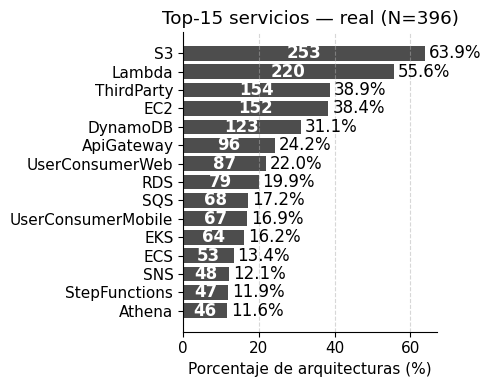

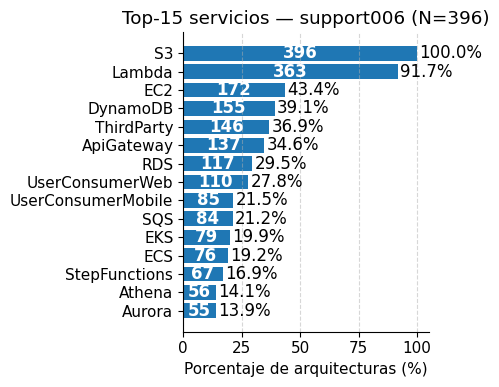

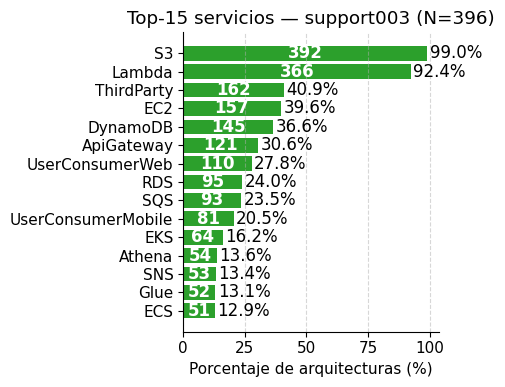

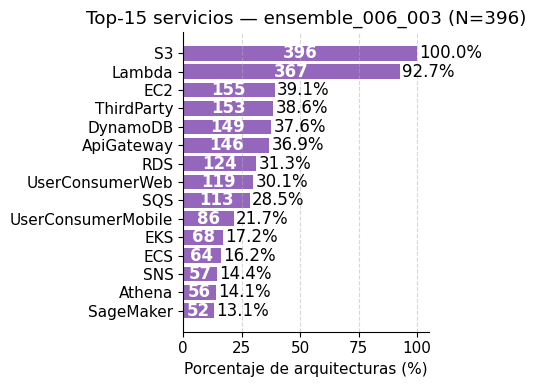

EPS exportados:
- fig_top15_real.eps
- fig_top15_support006.eps
- fig_top15_support003.eps
- fig_top15_ensemble_006_003.eps


In [ ]:
# ============================================================
# BLOCK A5.1 — Comparative metrics + EPS Figures (Top-15)
# ------------------------------------------------------------
# Requirements (from block GX):
#   - bundle with: gen_006, gen_003, gen_ensemble
#   - catalogs_all = mine_catalogs(...) already computed in GX
#   - df_all[['services','tipo_arquitectura']]
#   - utilities: _service_universe, _sizes_from_transactions,
#     _freq_vector (OOV-safe), jensen_shannon, _cooccurrence_matrix,
#     frobenius_norm, rules_delta_confidence, nn_jaccard_stats,
#     intra_jaccard_mean, coverage_ratio, normalized_entropy
# Outputs:
#   - CSV: gen_396_comparison_summary.csv
#   - EPS: fig_top15_real.eps, fig_top15_support006.eps,
#          fig_top15_support003.eps, fig_top15_ensemble_006_003.eps
# ============================================================

import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import matplotlib

# ---------- 0) Preparation ----------
# If you do not have the lists in memory for any reason, uncomment to load from PKL/CSV:
# gen_006      = pd.read_pickle("gen_396_support006.pkl")
# gen_003      = pd.read_pickle("gen_396_support003.pkl")
# gen_ensemble = pd.read_pickle("gen_396_ensemble_006_003.pkl")

tx_real = df_all["services"].tolist()
U_ref   = _service_universe(tx_real)   # reference universe (for coverage/entropy)

sets = {
    "support_006": gen_006,
    "support_003": gen_003,
    "ensemble_006_003": gen_ensemble
}

# ---------- 1) Comparative metrics (real vs generated) ----------
rows = []
for name, tx_gen in sets.items():
    # Sizes
    real_sizes = _sizes_from_transactions(tx_real)
    gen_sizes  = _sizes_from_transactions(tx_gen)
    ks = ks_2samp(real_sizes, gen_sizes, alternative="two-sided", mode="auto")
    wd = wasserstein_distance(real_sizes, gen_sizes)

    # Prevalence and Co-occurrences (evaluation universe = real ∪ generated)
    U_eval = _service_universe(tx_real + tx_gen)
    p_real = _freq_vector(tx_real, U_eval)
    p_gen  = _freq_vector(tx_gen,  U_eval)
    jsd    = jensen_shannon(p_real, p_gen, base=np.e)

    C_real = _cooccurrence_matrix(tx_real, U_eval)
    C_gen  = _cooccurrence_matrix(tx_gen,  U_eval)
    frob   = frobenius_norm(C_real, C_gen)

    # Rules (use the congruent catalog; ensemble averages both)
    if name.startswith("support_006"):
        _, rules_r = catalogs_all[0.06]
        delta = rules_delta_confidence(rules_r, tx_real, tx_gen, top_k=50)
    elif name.startswith("support_003"):
        _, rules_r = catalogs_all[0.03]
        delta = rules_delta_confidence(rules_r, tx_real, tx_gen, top_k=50)
    else:
        # ensemble: average delta (catalog 006 vs 003)
        _, rules_006 = catalogs_all[0.06]
        _, rules_003 = catalogs_all[0.03]
        d1 = rules_delta_confidence(rules_006, tx_real, tx_gen, top_k=50)
        d2 = rules_delta_confidence(rules_003, tx_real, tx_gen, top_k=50)
        delta = {
            "delta_mean":   np.nanmean([d1["delta_mean"],   d2["delta_mean"]]),
            "delta_median": np.nanmean([d1["delta_median"], d2["delta_median"]]),
            "delta_p95":    np.nanmean([d1["delta_p95"],    d2["delta_p95"]]),
            "n_eval":       int((d1["n_eval"] or 0) + (d2["n_eval"] or 0)) // 2
        }

    # Local realism
    nn = nn_jaccard_stats(tx_gen, tx_real)

    # Diversity (coverage/entropy referenced to the real universe)
    intra = intra_jaccard_mean(tx_gen)
    cov   = coverage_ratio(tx_gen, U_ref)
    Hn    = normalized_entropy(tx_gen, U_ref)

    rows.append({
        "set": name,
        "size_real_mean": float(np.mean(real_sizes)),
        "size_gen_mean":  float(np.mean(gen_sizes)),
        "KS_D": ks.statistic, "KS_p": ks.pvalue,
        "Wasserstein": wd,
        "JSD": jsd, "Frobenius": frob,
        "Rules_delta_mean": delta["delta_mean"],
        "Rules_delta_median": delta["delta_median"],
        "Rules_delta_p95": delta["delta_p95"],
        "NNJacc_mean": nn["mean"],
        "NNJacc_median": nn["median"],
        "NNJacc_p95": nn["p95"],
        "IntraJacc_mean": intra,
        "Coverage_ref": cov,
        "Entropy_norm_ref": Hn,
        "n_gen": len(tx_gen)
    })

df_summary = pd.DataFrame(rows).sort_values("set")
print("=== Comparative summary (real vs generated) ===")
print(df_summary.round(4).to_string(index=False))
df_summary.round(4).to_csv("gen_396_comparison_summary.csv", index=False)

# ---------- 2) EPS Figures — Top-15 services ----------
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11
})

def _top_counts(transactions, top_n=15):
    total = max(1, len(transactions))
    all_services = [s for t in transactions for s in set(t)]
    conteo = Counter(all_services).most_common(top_n)
    df_top = pd.DataFrame(conteo, columns=["Service", "Count"])
    df_top["Percentage"] = (df_top["Count"] / total) * 100
    return df_top, total

def _export_eps(fig, filename):
    fig.savefig(filename, format="eps", bbox_inches="tight")

def plot_top_services(name, transactions, color="#1F77B4", top_n=15):
    df_top, total = _top_counts(transactions, top_n=top_n)
    fig, ax = plt.subplots(figsize=(5, 4))
    bars = ax.barh(df_top["Service"], df_top["Percentage"], color=color)

    for bar, pct, n_abs in zip(bars, df_top["Percentage"], df_top["Count"]):
        ax.text(bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{n_abs}",
                ha='center', va='center',
                color='white', fontsize=12, fontweight='semibold')
        ax.text(bar.get_width() + 1,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                ha='left', va='center', fontsize=12)

    ax.set_title(f"Top-15 services — {name} (N={total})")
    ax.set_xlabel("Percentage of architectures (%)")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5); ax.yaxis.grid(False)
    ax.invert_yaxis()
    plt.tight_layout()
    _export_eps(fig, f"fig_top15_{name}.eps")
    plt.show()
    plt.close(fig)

# Real + 3 generated sets
plot_top_services("real",              tx_real,                      color="#4D4D4D")
plot_top_services("support006",        sets["support_006"],         color="#1F77B4")
plot_top_services("support003",        sets["support_003"],         color="#2CA02C")
plot_top_services("ensemble_006_003",  sets["ensemble_006_003"],    color="#9467BD")

print("Exported EPS:\n- fig_top15_real.eps\n- fig_top15_support006.eps\n- fig_top15_support003.eps\n- fig_top15_ensemble_006_003.eps")


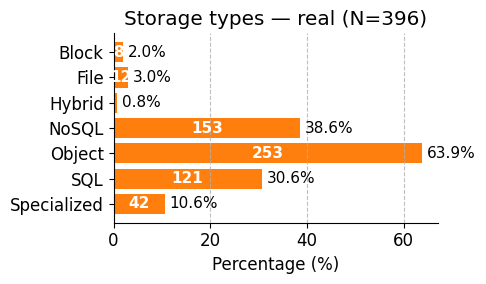

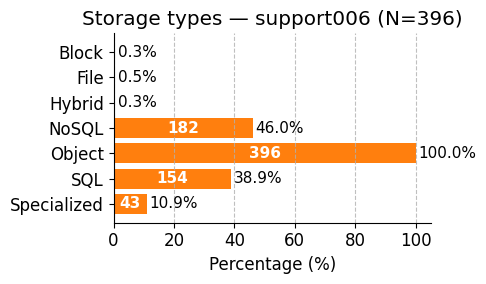

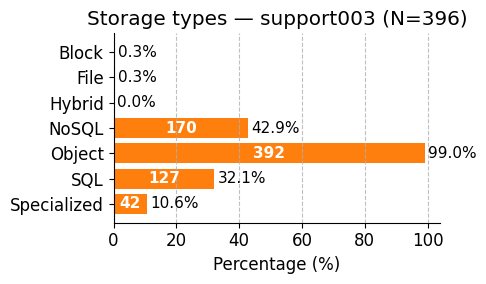

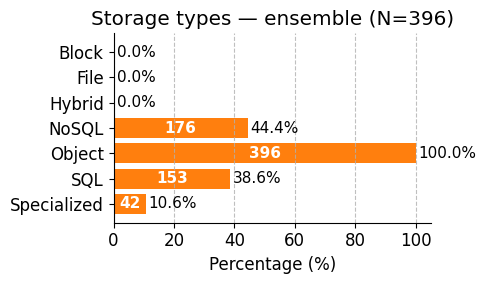

Listo:
- Figuras EPS: fig_storage_{real|support006|support003|ensemble}.eps
- CSVs por set: storage_comparison_{set}.csv
- CSV consolidado: storage_comparison_all_sets.csv


In [ ]:
# ============================================================
# BLOCK H2 — STORAGE comparison: Real vs 3 generated sets
# ------------------------------------------------------------
# Expected inputs in memory:
#   - df_all['services'] (list of services per architecture)
#   - gen_006, gen_003, gen_ensemble  (lists of generated architectures)
# Outputs:
#   - EPS: fig_storage_{real|support006|support003|ensemble}.eps
#   - Per-set CSV: storage_comparison_{set}.csv
#   - Consolidated CSV: storage_comparison_all_sets.csv
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

# ---------- Figure style ----------
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12
})

# ---------- Storage taxonomy (case-insensitive) ----------
storage_taxonomy = {
    # Object
    "S3": "Object", "MediaStore": "Object",
    # File
    "EFS": "File", "FSX": "File", "FSx": "File",
    # SQL
    "RDS": "SQL", "Aurora": "SQL",
    # NoSQL / Cache
    "DynamoDB": "NoSQL", "DocumentDB": "NoSQL", "MemoryDB": "NoSQL", "ElastiCache": "NoSQL",
    # Specialized
    "RedShift": "Specialized", "Redshift": "Specialized", "Neptune": "Specialized", "Timestream": "Specialized",
    # Block / Hybrid
    "EBS": "Block", "StorageGateway": "Hybrid",
}
TAX = {k.strip().lower(): v for k, v in storage_taxonomy.items()}

# Consistent order on Y-axis
ORDER = ["Specialized", "SQL", "Object", "NoSQL", "Hybrid", "File", "Block"]

# ---------- Sets to compare ----------
tx_real = df_all["services"].tolist()
SETS = {
    "real":              tx_real,
    "support006":        gen_006,
    "support003":        gen_003,
    "ensemble":          gen_ensemble,
}

# ---------- Utility: storage summary per set ----------
def storage_summary(transactions):
    """
    Cuenta, por arquitectura, la presencia (>=1) de cada tipo de almacenamiento.
    Devuelve:
      - df_counts: conteos por tipo
      - df_pct:    porcentajes por tipo (% de arquitecturas que lo incluyen)
    """
    total = max(1, len(transactions))
    counts = Counter({t: 0 for t in ORDER})
    for arch in transactions:
        tipos_presentes = set()
        for s in set(str(x).strip().lower() for x in arch):
            if s in TAX:
                tipos_presentes.add(TAX[s])
        for t in tipos_presentes:
            counts[t] += 1
    df_counts = pd.Series(counts).loc[ORDER].rename("count").to_frame()
    df_pct = (df_counts["count"] / total * 100.0).round(1).rename("pct").to_frame()
    return df_counts, df_pct, total

# ---------- Utility: EPS plot styled like the example ----------
def plot_storage_eps(name, df_counts, df_pct, total, color="#FF7F0E"):
    tipos = df_pct.index.tolist()
    valores = df_pct["pct"].tolist()

    fig, ax = plt.subplots(figsize=(5, 3))
    bars = ax.barh(tipos, valores, color=color)

    for bar, tipo, pct in zip(bars, tipos, valores):
        n_abs = int(df_counts.loc[tipo, "count"])
        y = bar.get_y() + bar.get_height()/2
        # absolute number inside the bar (if width allows)
        if bar.get_width() > 1:
            ax.text(bar.get_width()*0.5, y, f"{n_abs}",
                    ha="center", va="center", color="white",
                    fontsize=11, fontweight="semibold")
        # percentage outside
        ax.text(bar.get_width()+1, y, f"{pct:.1f}%",
                ha="left", va="center", fontsize=11)

    ax.set_xlabel("Percentage (%)")
    ax.set_title(f"Storage types — {name} (N={total})")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.8); ax.yaxis.grid(False)
    plt.tight_layout()
    fig.savefig(f"fig_storage_{name}.eps", format="eps", bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ---------- Run for each set and save CSV ----------
rows_all = []
for name, tx in SETS.items():
    df_counts, df_pct, N = storage_summary(tx)
    # save per-set CSV
    out = pd.concat([df_counts.T, df_pct.T], axis=0)
    out.index = ["count", "pct"]
    out.to_csv(f"storage_comparison_{name}.csv")
    # EPS figure
    plot_storage_eps(name, df_counts, df_pct, N, color="#FF7F0E")
    # accumulate for consolidated CSV
    rec = {"set": name, "N": N}
    for t in ORDER:
        rec[f"{t}_count"] = int(df_counts.loc[t, "count"])
        rec[f"{t}_pct"]   = float(df_pct.loc[t, "pct"])
    rows_all.append(rec)

# ---------- Consolidated CSV ----------
df_all_sets = pd.DataFrame(rows_all).set_index("set")
df_all_sets.to_csv("storage_comparison_all_sets.csv")
print("Done:")
print("- EPS figures: fig_storage_{real|support006|support003|ensemble}.eps")
print("- Per-set CSVs: storage_comparison_{set}.csv")
print("- Consolidated CSV: storage_comparison_all_sets.csv")


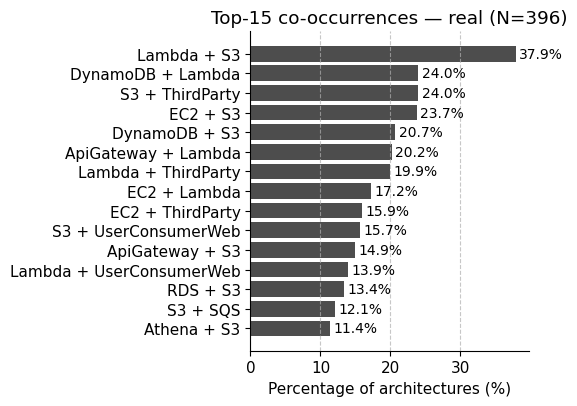

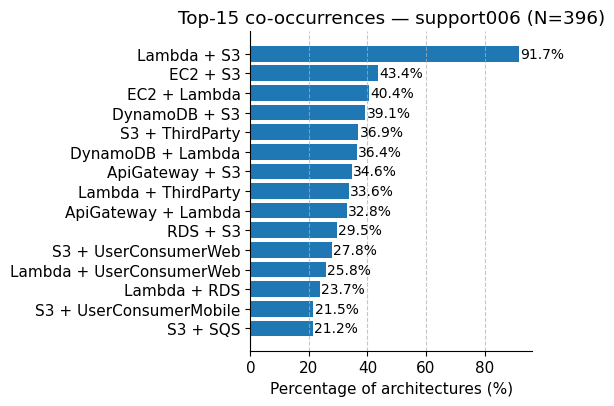

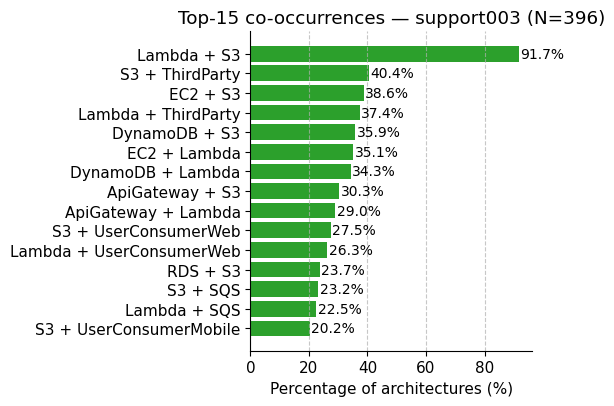

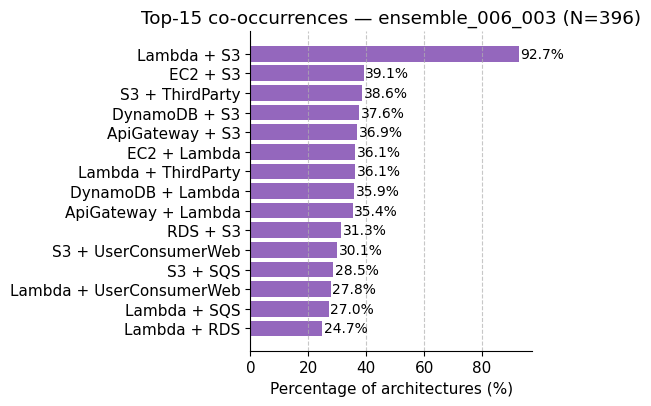

EPS guardados (Top-15):
- fig_cooc_top15_real.eps
- fig_cooc_top15_support006.eps
- fig_cooc_top15_support003.eps
- fig_cooc_top15_ensemble_006_003.eps

=== Resumen co-ocurrencias (real vs generados) ===
             set  Frobenius_real_vs_set  Pearson_upper_real_vs_set  Top15_overlap_count  Top15_real_count  Top15_set_count  Top15_overlap_ratio
      support006                 1.5379                     0.9417                   13                15               15               0.8667
      support003                 1.3730                     0.9488                   13                15               15               0.8667
ensemble_006_003                 1.5361                     0.9421                   13                15               15               0.8667

CSV guardado: cooccurrence_comparison_summary.csv


In [ ]:
# ============================================================
# ============================================================
# BLOCK A5 — Co-occurrence comparison (real vs 3 generated sets)
# ------------------------------------------------------------
# Does:
#   (1) Builds normalized co-occurrence matrices for:
#       real, support006, support003, ensemble_006_003
#       using a COMMON service UNIVERSE (union of the 4 sets).
#   (2) Exports EPS with Top-15 pairs per set.
#   (3) Creates a comparative table (CSV) with Frobenius, Pearson(r) and
#       Top-15 overlap with respect to the real set.
# ============================================================

from collections import Counter
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# ---------- Plot style ----------
matplotlib.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 11})
COLOR_SET = {
    "real": "#4D4D4D",
    "support006": "#1F77B4",
    "support003": "#2CA02C",
    "ensemble_006_003": "#9467BD"
}

# ---------- Input data ----------
tx_real      = df_all["services"].tolist()
tx_support06 = gen_006
tx_support03 = gen_003
tx_ens       = gen_ensemble

sets = {
    "real": tx_real,
    "support006": tx_support06,
    "support003": tx_support03,
    "ensemble_006_003": tx_ens
}

# ---------- 1) Common service universe ----------
def service_universe_all(sets_dict):
    U = set()
    for tx in sets_dict.values():
        for t in tx:
            U.update(t)
    return sorted(U)

U_all = service_universe_all(sets)

# ---------- 2) Normalized co-occurrence matrix ----------
def cooccurrence_matrix(transactions, universe):
    idx = {s:i for i,s in enumerate(universe)}
    n = len(universe)
    M = np.zeros((n, n), dtype=float)
    for t in transactions:
        uniq = sorted({s for s in t if s in idx})
        for i in range(len(uniq)):
            for j in range(i, len(uniq)):
                a = idx[uniq[i]]; b = idx[uniq[j]]
                M[a,b] += 1.0
                if a != b: M[b,a] += 1.0
    m = max(1.0, len(transactions))
    return M / m

M = {name: cooccurrence_matrix(tx, U_all) for name, tx in sets.items()}

# ---------- 3) Distances/Correlations between matrices ----------
def frobenius_norm(A, B):
    D = A - B
    return float(np.sqrt((D*D).sum()))

def pearson_upper(A, B):
    # Pearson correlation on the upper triangle (includes diagonal)
    iu = np.triu_indices_from(A)
    a = A[iu].ravel()
    b = B[iu].ravel()
    if a.std() == 0 or b.std() == 0:
        return np.nan
    return float(np.corrcoef(a, b)[0,1])

# ---------- 4) Top-N pairs per set ----------
from collections import defaultdict

def top_pairs_from_matrix(Mset, universe, top_n=15):
    # extract pairs (i<j) with the highest co-occurrence probability
    n = len(universe)
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            pairs.append(((universe[i], universe[j]), Mset[i,j]))
    pairs.sort(key=lambda x: x[1], reverse=True)
    pairs = pairs[:top_n]
    # to dataframe
    df = pd.DataFrame(pairs, columns=["Par", "Prob"])
    df["ParStr"] = df["Par"].apply(lambda ab: f"{ab[0]} + {ab[1]}")
    df["Porcentaje"] = df["Prob"]*100.0
    return df[["Par","ParStr","Porcentaje"]]

# ---------- 5) EPS plot Top-15 ----------
def export_eps(fig, filename):
    fig.savefig(filename, format="eps", bbox_inches="tight")

def plot_topN(name, df_top, color):
    if df_top is None or df_top.empty:
        print(f"[WARN] Empty Top-N for {name}")
        return
    fig, ax = plt.subplots(figsize=(5.8, 4.2))
    ax.barh(df_top["ParStr"], df_top["Porcentaje"], color=color)
    # annotate %
    for bar, pct in zip(ax.patches, df_top["Porcentaje"]):
        ax.text(bar.get_width()+0.5,
                bar.get_y()+bar.get_height()/2,
                f"{pct:.1f}%",
                va='center', fontsize=10)
    ax.set_title(f"Top-15 co-occurrences — {name} (N={len(sets[name])})")
    ax.set_xlabel("Percentage of architectures (%)")
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7); ax.yaxis.grid(False)
    plt.tight_layout()
    export_eps(fig, f"fig_cooc_top15_{name}.eps")
    plt.show()
    plt.close(fig)

TOP_N = 15
tops = {}
for name, Mset in M.items():
    df_top = top_pairs_from_matrix(Mset, U_all, top_n=TOP_N)
    tops[name] = df_top
    plot_topN(name, df_top, COLOR_SET.get(name, "#1F77B4"))

print("Saved EPS (Top-15):",
      *[f"fig_cooc_top15_{k}.eps" for k in sets.keys()], sep="\n- ")

# ---------- 6) Top-15 overlap with the real set ----------
def overlap_top(real_df, other_df):
    R = set(map(tuple, real_df["Par"]))    # set of pairs (a,b)
    O = set(map(tuple, other_df["Par"]))
    inter = R & O
    return len(inter), len(R), len(O), len(inter)/max(1,len(R))

# Real vs generated comparison
rows = []
for target in ["support006", "support003", "ensemble_006_003"]:
    frob = frobenius_norm(M["real"], M[target])
    pr   = pearson_upper(M["real"], M[target])
    k, r_total, o_total, ratio = overlap_top(tops["real"], tops[target])
    rows.append({
        "set": target,
        "Frobenius_real_vs_set": frob,
        "Pearson_upper_real_vs_set": pr,
        "Top15_overlap_count": k,
        "Top15_real_count": r_total,
        "Top15_set_count": o_total,
        "Top15_overlap_ratio": ratio
    })

df_cooc_summary = pd.DataFrame(rows)
print("\n=== Co-occurrence summary (real vs generated) ===")
print(df_cooc_summary.round(4).to_string(index=False))
df_cooc_summary.round(4).to_csv("cooccurrence_comparison_summary.csv", index=False)
print("\nSaved CSV: cooccurrence_comparison_summary.csv")


# Block B1: EDGE Categories

In [ ]:
# ============================================================
# BLOCK B1 — Edge subset (101 architectures)
# ------------------------------------------------------------
# Objective:
#   - Filter only architectures labeled as "Edge".
#   - Validate subset size and number of services per architecture.
#   - Extract the most frequent services as an initial diagnostic.
# ============================================================

import pandas as pd
from collections import Counter
import numpy as np

# 1) Filter Edge subset
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].copy()
tx_edge = df_edge["services"].tolist()   # list of lists (transactions)

# 2) Basic summary
n_edge = len(df_edge)
sizes_edge = [len(set(t)) for t in tx_edge]

print("=== Edge subset summary ===")
print(f"Number of Edge architectures: {n_edge}")
print(f"Average number of services per architecture: {np.mean(sizes_edge):.2f}")
print(f"Minimum size: {np.min(sizes_edge)}, maximum: {np.max(sizes_edge)}")

# 3) Top-15 most frequent services
all_services = [s for t in tx_edge for s in set(t)]
conteo = Counter(all_services).most_common(15)

print("\nTop-15 services in Edge:")
for serv, freq in conteo:
    pct = (freq / n_edge) * 100
    print(f" - {serv:<25} {freq:>3} architectures ({pct:5.1f}%)")


=== Resumen subconjunto Edge ===
N° de arquitecturas Edge: 101
Tamaño medio de servicios por arquitectura: 8.50
Tamaño mínimo: 3, máximo: 14

Top-15 servicios en Edge:
 - S3                         77 arquitecturas ( 76.2%)
 - Lambda                     61 arquitecturas ( 60.4%)
 - CloudFront                 41 arquitecturas ( 40.6%)
 - DynamoDB                   40 arquitecturas ( 39.6%)
 - EC2                        34 arquitecturas ( 33.7%)
 - ThirdParty                 33 arquitecturas ( 32.7%)
 - ApiGateway                 32 arquitecturas ( 31.7%)
 - UserConsumerWeb            27 arquitecturas ( 26.7%)
 - UserConsumerMobile         25 arquitecturas ( 24.8%)
 - RDS                        21 arquitecturas ( 20.8%)
 - UserConsumerEdge           20 arquitecturas ( 19.8%)
 - Kinesis                    16 arquitecturas ( 15.8%)
 - SQS                        16 arquitecturas ( 15.8%)
 - Firehose                   15 arquitecturas ( 14.9%)
 - Athena                     14 arquitecturas (

Minado de itemsets frecuentes

In [ ]:
# ============================================================
# BLOCK E1 — FP-Growth on Edge Architectures
# ------------------------------------------------------------
# Objective:
#   - Mine frequent itemsets (services or combinations of services).
#   - Use two support thresholds (0.06 and 0.03) to compare diversity.
#   - Also export association rules (confidence and lift).
# ============================================================

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# ---------- Parameters ----------
SUPPORTS = [0.06, 0.03]   # minimum supports to test
CONF_MIN = 0.60           # minimum confidence
LIFT_MIN = 1.05           # minimum lift

# ---------- Binary transformation ----------
te = TransactionEncoder()
te_ary = te.fit(tx_edge).transform(tx_edge)
df_bin = pd.DataFrame(te_ary, columns=te.columns_)

# ---------- Results for each support ----------
catalogs_edge = {}
for sup in SUPPORTS:
    # 1) Frequent itemsets
    fis = fpgrowth(df_bin, min_support=sup, use_colnames=True)
    fis = fis.sort_values("support", ascending=False)

    # 2) Association rules
    rules = association_rules(fis, metric="confidence", min_threshold=CONF_MIN)
    rules = rules[rules["lift"] >= LIFT_MIN].copy()
    rules["antecedents"] = rules["antecedents"].apply(lambda x: set(x))
    rules["consequents"] = rules["consequents"].apply(lambda x: set(x))

    catalogs_edge[sup] = (fis, rules)

    print(f"\n=== Results support={sup:.2f} ===")
    print(f"Frequent itemsets found: {len(fis)}")
    print(f"Rules generated (conf ≥ {CONF_MIN}, lift ≥ {LIFT_MIN}): {len(rules)}")
    print("\nTop-5 frequent itemsets example:")
    print(fis.head())
    print("\nTop-5 association rules example:")
    print(rules[["antecedents","consequents","support","confidence","lift"]].head())



=== Resultados soporte=0.06 ===
Itemsets frecuentes encontrados: 188
Reglas generadas (conf ≥ 0.6, lift ≥ 1.05): 112

Ejemplo de itemsets top-5:
     support      itemsets
0   0.762376          (S3)
7   0.603960      (Lambda)
82  0.435644  (S3, Lambda)
8   0.405941  (CloudFront)
14  0.396040    (DynamoDB)

Ejemplo de reglas top-5:
         antecedents consequents   support  confidence      lift
1       {CloudFront}        {S3}  0.346535    0.853659  1.119734
2         {DynamoDB}    {Lambda}  0.297030    0.750000  1.241803
3              {EC2}        {S3}  0.277228    0.823529  1.080214
5       {ApiGateway}    {Lambda}  0.237624    0.750000  1.241803
7  {UserConsumerWeb}        {S3}  0.217822    0.814815  1.068783

=== Resultados soporte=0.03 ===
Itemsets frecuentes encontrados: 588
Reglas generadas (conf ≥ 0.6, lift ≥ 1.05): 575

Ejemplo de itemsets top-5:
      support      itemsets
0    0.762376          (S3)
7    0.603960      (Lambda)
163  0.435644  (S3, Lambda)
8    0.405941  (Cl

#Block B2: Evaluation using 10-fold x3

In [ ]:
# ============================================================
# BLOCK B2 — Edge: 10-fold (repeated) with full metrics
# ------------------------------------------------------------
# Evaluates the generator on the Edge subset (101 architectures)
# Metrics per fold: JSD, Frobenius, NN-Jaccard, intra-Jaccard,
# coverage, normalized entropy, and average generated size.
# Exports a CSV with per-fold rows and a summary (95% CI).
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from scipy.stats import entropy
from math import log

# ---------- Parameters ----------
K = 10
N_REPEATS = 3
SUPPORTS = (0.06, 0.03)
CONF_MIN = 0.60
LIFT_MIN = 1.05
MAX_SIZE = 10
N_CANDS  = 100
SEED_BASE = 8100

# ---------- Generic utilities ----------
def _agg_ci(x):
    a = np.asarray(x, dtype=float)
    if a.size == 0:
        return dict(mean=np.nan, p2_5=np.nan, p97_5=np.nan)
    return dict(mean=float(a.mean()),
                p2_5=float(np.percentile(a, 2.5)),
                p97_5=float(np.percentile(a, 97.5)))

def _sizes_from_transactions(tx):
    return [len(set(t)) for t in tx]

def _service_universe(transactions):
    u = set()
    for t in transactions: u.update(t)
    return sorted(u)

def _freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    U = set(universe)
    for t in transactions:
        for s in set(t):
            if s in U:
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())
    return v

def jensen_shannon(p, q, base=np.e):
    p = np.maximum(np.asarray(p, float), 1e-12); p = p/p.sum()
    q = np.maximum(np.asarray(q, float), 1e-12); q = q/q.sum()
    m = 0.5*(p+q)
    return 0.5*entropy(p, m, base=base) + 0.5*entropy(q, m, base=base)

def _cooccurrence_matrix(transactions, universe):
    idx = {s:i for i,s in enumerate(universe)}
    n = len(universe)
    M = np.zeros((n, n), dtype=float)
    for t in transactions:
        tt = sorted({s for s in t if s in idx})
        for i in range(len(tt)):
            for j in range(i, len(tt)):
                a,b = idx[tt[i]], idx[tt[j]]
                M[a,b] += 1.0
                if a!=b: M[b,a] += 1.0
    m = max(1.0, len(transactions))
    return M/m

def frobenius_norm(A, B):
    D = A - B
    return float(np.sqrt((D*D).sum()))

def jaccard(a, b):
    A,B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B)/max(1.0, len(A | B))

def nn_jaccard_stats(tx_gen, tx_real):
    if len(tx_gen)==0 or len(tx_real)==0:
        return dict(mean=np.nan, median=np.nan, p95=np.nan)
    vals = []
    for g in tx_gen:
        best = 0.0
        for r in tx_real:
            best = max(best, jaccard(g, r))
        vals.append(best)
    vals = np.asarray(vals, float)
    return dict(mean=float(vals.mean()),
                median=float(np.median(vals)),
                p95=float(np.percentile(vals, 95)))

def intra_jaccard_mean(tx):
    n = len(tx)
    if n<2: return np.nan
    s=0.0; c=0
    for i in range(n):
        for j in range(i+1, n):
            s += jaccard(tx[i], tx[j]); c += 1
    return float(s/c)

def coverage_ratio(tx, universe):
    seen=set()
    for t in tx: seen.update(t)
    return len(seen)/max(1.0, len(universe))

def normalized_entropy(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    for t in transactions:
        for s in set(t):
            if s in counts: counts[s]+=1
    v = np.array([counts[s] for s in universe], dtype=float)
    if v.sum()==0: return np.nan
    p = v/v.sum()
    h = entropy(p, base=np.e)
    return float(h / max(1.0, log(len(universe))))

# ---------- Mining (uses your function from E1) ----------
# Must exist: mine_catalogs(transactions, supports, conf_min, lift_min)
# and generate_architecture_size_aware(seed, rules, fis, df_train, ...)

rows = []
X = df_edge["services"].to_list()

for rep in range(N_REPEATS):
    kf = KFold(n_splits=K, shuffle=True, random_state=SEED_BASE+rep)
    for fold_idx, (tr, te) in enumerate(kf.split(X)):
        # Edge partitions
        tx_train = [X[i] for i in tr]
        tx_test  = [X[i] for i in te]
        n_test   = len(tx_test)

        # Auxiliary train DataFrame for size-aware generation and seed selection
        df_train = df_edge.iloc[tr].copy()

        # Mining on train
        catalogs = mine_catalogs(tx_train,
                                 supports=SUPPORTS,
                                 conf_min=CONF_MIN,
                                 lift_min=LIFT_MIN)

        # Universe for distributional metrics
        universe = _service_universe(tx_train)

        # Seeds (50% real + 50% hybrid from train)
        seeds = select_seeds(df_train, k=n_test, mix_ratio=0.5,
                             random_state=SEED_BASE + rep*100 + fold_idx)

        for cfg in ("006","003"):
            fis, rules = catalogs[0.06] if cfg=="006" else catalogs[0.03]

            # Size-aware generation
            gen = []
            for i in range(n_test):
                arch = generate_architecture_size_aware(
                    seeds[i], rules, fis, df_train,
                    max_size=MAX_SIZE, n_candidates=N_CANDS,
                    require_edge=False,
                    random_state=SEED_BASE + rep*10_000 + fold_idx*100 + i
                )
                if arch: gen.append(arch)

            # ---- Metrics
            real_mean = float(np.mean(_sizes_from_transactions(tx_test)))
            gen_mean  = float(np.mean(_sizes_from_transactions(gen)))

            p_real = _freq_vector(tx_test, universe)
            p_gen  = _freq_vector(gen,      universe)
            jsd = float(jensen_shannon(p_real, p_gen))

            C_real = _cooccurrence_matrix(tx_test, universe)
            C_gen  = _cooccurrence_matrix(gen,      universe)
            frob = frobenius_norm(C_real, C_gen)

            nn = nn_jaccard_stats(gen, tx_test)
            intra = intra_jaccard_mean(gen)
            cov   = coverage_ratio(gen, universe)
            Hn    = normalized_entropy(gen, universe)

            rows.append({
                "rep": rep, "fold": fold_idx, "config": cfg,
                "gen_mean": gen_mean,
                "jsd": jsd, "frob": frob,
                "nn_jacc_mean": nn["mean"],
                "nn_jacc_median": nn["median"],
                "nn_jacc_p95": nn["p95"],
                "intra_jacc_mean": intra,
                "coverage": cov,
                "entropy_norm": Hn,
                "n_test": n_test, "n_gen": len(gen)
            })

df_edge_cv = pd.DataFrame(rows)

# ---------- Summary (mean + 95% CI) ----------
def summarize_cfg(df, cfg):
    sub = df[df["config"]==cfg]
    def s(col):
        a = sub[col].dropna().values
        out = _agg_ci(a)
        return pd.Series({
            f"{col}_mean": out["mean"],
            f"{col}_p2.5": out["p2_5"],
            f"{col}_p97.5": out["p97_5"]
        })
    cols = ["gen_mean","jsd","frob",
            "nn_jacc_mean","nn_jacc_median","nn_jacc_p95",
            "intra_jacc_mean","coverage","entropy_norm"]
    parts = [s(c) for c in cols]
    parts.append(pd.Series({"N_folds": len(sub)}))
    return pd.concat(parts)

summary = pd.concat({
    "support_0.06": summarize_cfg(df_edge_cv, "006"),
    "support_0.03": summarize_cfg(df_edge_cv, "003"),
}, axis=1)

print("=== Edge — 10-fold (repeated) — Full metrics ===")
print(summary.round(4).to_string())

# Save
df_edge_cv.to_csv("edge_cv10x3_full_metrics.csv", index=False)
summary.round(4).to_csv("edge_cv10x3_full_summary.csv")
print("Files saved:\n- edge_cv10x3_full_metrics.csv\n- edge_cv10x3_full_summary.csv")


=== Edge — 10-fold (repetido) — métricas completas ===
                       support_0.06  support_0.03
gen_mean_mean                8.1879        8.5667
gen_mean_p2.5                7.4545        7.8132
gen_mean_p97.5               8.9000        9.1550
jsd_mean                     0.1793        0.1939
jsd_p2.5                     0.1401        0.1425
jsd_p97.5                    0.2412        0.2707
frob_mean                    3.6502        3.9166
frob_p2.5                    3.0110        3.1612
frob_p97.5                   4.5228        4.6678
nn_jacc_mean_mean            0.3332        0.3393
nn_jacc_mean_p2.5            0.2901        0.2724
nn_jacc_mean_p97.5           0.3947        0.3972
nn_jacc_median_mean          0.3270        0.3345
nn_jacc_median_p2.5          0.2736        0.2621
nn_jacc_median_p97.5         0.3878        0.3946
nn_jacc_p95_mean             0.4489        0.4515
nn_jacc_p95_p2.5             0.3737        0.3644
nn_jacc_p95_p97.5            0.6046        0.

Generation of 101 EDGE architectures (0.3-0.6-MIX)

In [ ]:
# ============================================================
# BLOCK G-EDGE — Generation of 101 EDGE Architectures
# ------------------------------------------------------------
# Configurations:
#   - support 0.03
#   - support 0.06
#   - mixed (50% 0.03 + 50% 0.06)
# Output:
#   - edge_gen_101_support03.csv
#   - edge_gen_101_support06.csv
#   - edge_gen_101_mix.csv
# ============================================================

import pandas as pd
import numpy as np

# ---------- Parameters ----------
N_GEN = 101
MAX_SIZE = 10
N_CANDS = 100
SEED_BASE = 9000

# ---------- Mining catalogs ONLY from Edge architectures ----------
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].reset_index(drop=True)

catalogs_edge = mine_catalogs(
    df_edge["services"].tolist(),
    supports=(0.06, 0.03),
    conf_min=0.60,
    lift_min=1.05
)

# ---------- Generic generator ----------
def generate_batch_edge(fis, rules, n_target, random_state_base):
    gens = []
    seeds = select_seeds(df_edge, k=n_target, mix_ratio=0.5, random_state=random_state_base)
    for i in range(n_target):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_edge,
            max_size=MAX_SIZE, n_candidates=N_CANDS,
            require_edge=True,  # <- enforce EDGE architectures
            random_state=random_state_base + i
        )
        if arch:
            gens.append(arch)
    return gens

# ---------- Generation with 3 configurations ----------
gens_03 = generate_batch_edge(*catalogs_edge[0.03], N_GEN, SEED_BASE + 1)
gens_06 = generate_batch_edge(*catalogs_edge[0.06], N_GEN, SEED_BASE + 2)

# Mixed: half with 0.03 rules and half with 0.06 rules
gens_mix = []
gens_mix += generate_batch_edge(*catalogs_edge[0.03], N_GEN // 2, SEED_BASE + 3)
gens_mix += generate_batch_edge(*catalogs_edge[0.06], N_GEN - N_GEN // 2, SEED_BASE + 4)

# ---------- Save to CSV ----------
def save_csv(gens, fname):
    pd.DataFrame({"services": gens, "tipo_arquitectura": ["Edge"] * len(gens)}).to_csv(fname, index=False)

save_csv(gens_03, "edge_gen_101_support03.csv")
save_csv(gens_06, "edge_gen_101_support06.csv")
save_csv(gens_mix, "edge_gen_101_mix.csv")

print("Files generated:")
print(" - edge_gen_101_support03.csv")
print(" - edge_gen_101_support06.csv")
print(" - edge_gen_101_mix.csv")


Archivos generados:
 - edge_gen_101_support03.csv
 - edge_gen_101_support06.csv
 - edge_gen_101_mix.csv


In [ ]:
# ============================================================
# BLOCK G-EDGE (EVALUATION) — Metrics and EPS Figures
# ------------------------------------------------------------
# Evaluates 3 generated files (0.03, 0.06, mixed) against real Edge:
#  - Size (#services)
#  - Prevalence (Jensen–Shannon Divergence)
#  - Co-occurrences (Frobenius of P(i∧j) matrix)
#  - Local realism (NN-Jaccard: mean/median/P95)
#  - Diversity (intra-Jaccard, coverage, normalized entropy)
# Exports:
#  - edge_eval_three_sets_summary.csv (comparative table)
#  - EPS: Top-15 services and Top-10 co-occurrences (real and 3 generated)
# ============================================================

import ast
import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations
from scipy.stats import entropy
import matplotlib.pyplot as plt
import matplotlib

# ---------- Plot style ----------
matplotlib.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11
})

def export_eps(fig, filename):
    fig.savefig(filename, format="eps", bbox_inches="tight")

# ---------- Parsing utilities ----------
def parse_services_column(df, col="services"):
    """Converts a column containing list-like strings into Python lists."""
    out = []
    for x in df[col].tolist():
        if isinstance(x, list):
            out.append(x)
        else:
            try:
                out.append(ast.literal_eval(str(x)))
            except Exception:
                # very simple fallback: comma-split
                out.append([t.strip() for t in str(x).strip("[]").split(",") if t.strip()])
    return out

# ---------- Metric utilities ----------
def service_universe(transactions):
    u = set()
    for t in transactions: u.update(t)
    return sorted(u)

def freq_vector(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    U = set(universe)
    for t in transactions:
        for s in set(t):
            if s in U:
                counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    v = v / max(1.0, v.sum())
    return v

def jensen_shannon(p, q, base=np.e):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    eps = 1e-12
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    p /= p.sum(); q /= q.sum()
    m = 0.5*(p+q)
    return 0.5*entropy(p, m, base=base) + 0.5*entropy(q, m, base=base)

def cooccurrence_matrix(transactions, universe):
    idx = {s:i for i,s in enumerate(universe)}
    n = len(universe)
    M = np.zeros((n,n), dtype=float)
    for t in transactions:
        tt = sorted({s for s in t if s in idx})
        for i in range(len(tt)):
            for j in range(i, len(tt)):
                a, b = idx[tt[i]], idx[tt[j]]
                M[a,b] += 1.0
                if a != b: M[b,a] += 1.0
    m = max(1.0, len(transactions))
    return M/m

def frobenius_norm(A, B):
    D = A - B
    return float(np.sqrt((D*D).sum()))

def jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1.0
    return len(A & B) / max(1.0, len(A | B))


def nn_jaccard_stats(tx_gen, tx_real):
    if len(tx_gen)==0 or len(tx_real)==0:
        return dict(mean=np.nan, median=np.nan, p95=np.nan)
    vals = []
    for g in tx_gen:
        best = 0.0
        for r in tx_real:
            best = max(best, jaccard(g, r))
        vals.append(best)
    vals = np.asarray(vals, dtype=float)
    return dict(mean=float(vals.mean()),
                median=float(np.median(vals)),
                p95=float(np.percentile(vals, 95)))

def intra_jacc_mean(tx):
    """
    Computes the average Jaccard similarity across ALL architectures
    in a set (measures internal diversity).
    """
    n = len(tx)
    if n < 2:
        return np.nan
    s = 0.0
    c = 0
    for i in range(n):
        for j in range(i+1, n):
            s += jaccard(tx[i], tx[j])
            c += 1
    return float(s / c)


def intra_jaccard_mean(tx):
    n = len(tx)
    if n < 2: return np.nan
    s = 0.0; c = 0
    for i in range(n):
        for j in range(i+1, n):
            s += jaccard(tx[i], tx[j]); c += 1
    return float(s/c)

def coverage_ratio(tx, universe):
    seen = set()
    for t in tx: seen.update(t)
    return len(seen) / max(1.0, len(universe))

def normalized_entropy(transactions, universe):
    counts = dict.fromkeys(universe, 0)
    U = set(universe)
    for t in transactions:
        for s in set(t):
            if s in U: counts[s] += 1
    v = np.array([counts[s] for s in universe], dtype=float)
    if v.sum() == 0: return np.nan
    p = v / v.sum()
    h = entropy(p, base=np.e)
    return float(h / max(1.0, np.log(len(universe))))

def sizes_from_transactions(tx):
    return [len(set(t)) for t in tx]

# ---------- Plots ----------
COLOR_REAL = "#1F77B4"
COLOR_GEN  = "#FF7F0E"

def plot_top_services(transactions, title, filename_eps, color=COLOR_GEN, top_n=15):
    total = len(transactions)
    flat = [s for t in transactions for s in set(t)]
    cnt  = Counter(flat).most_common(top_n)
    df = pd.DataFrame(cnt, columns=["Service","Count"])
    df["Percentage"] = 100.0 * df["Count"] / max(1, total)

    fig, ax = plt.subplots(figsize=(6.0,4.2))
    bars = ax.barh(df["Service"], df["Percentage"], color=color)
    for bar, pct, n in zip(bars, df["Percentage"], df["Count"]):
        ax.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, f"{n}",
                ha="center", va="center", color="white", fontsize=11, fontweight="semibold")
        ax.text(bar.get_width()+0.8, bar.get_y()+bar.get_height()/2, f"{pct:.1f}%", va="center", fontsize=11)
    ax.set_xlabel("Percentage of architectures (%)")
    ax.invert_yaxis()
    ax.spines['top'].setVisible = False; ax.spines['right'].setVisible = False
    ax.xaxis.grid(True, linestyle="--", alpha=0.6); ax.yaxis.grid(False)
    plt.tight_layout()
    export_eps(fig, filename_eps)
    plt.close(fig)

def plot_top_cooc(transactions, title, filename_eps, color=COLOR_GEN, top_n=10):
    total = len(transactions)
    cooc = Counter()
    for t in transactions:
        tu = sorted(set(t))
        for a,b in combinations(tu, 2):
            cooc[(a,b)] += 1
    pairs = [(f"{a} + {b}", c) for (a,b),c in cooc.items()]
    df = pd.DataFrame(pairs, columns=["Pair","Count"]).sort_values("Count", ascending=False).head(top_n)
    df["Percentage"] = 100.0 * df["Count"] / max(1, total)

    fig, ax = plt.subplots(figsize=(6.0,4.2))
    bars = ax.barh(df["Pair"], df["Percentage"], color=color)
    for bar, pct in zip(bars, df["Percentage"]):
        ax.text(bar.get_width()+0.6, bar.get_y()+bar.get_height()/2, f"{pct:.1f}%", va="center")
    ax.set_xlabel("Percentage of architectures (%)")
    ax.invert_yaxis()
    ax.spines['top'].setVisible = False; ax.spines['right'].setVisible = False
    ax.xaxis.grid(True, linestyle="--", alpha=0.6); ax.yaxis.grid(False)
    plt.tight_layout()
    export_eps(fig, filename_eps)
    plt.close(fig)

# ============================================================
# 1) Reference: real Edge
# ============================================================
df_edge = df_all[df_all["tipo_arquitectura"]=="Edge"].reset_index(drop=True)
tx_real = parse_services_column(df_edge, "services")
universe = service_universe(tx_real)

# ============================================================
# 2) Load the 3 generated sets
# ============================================================
files = {
    "support_0.03": "edge_gen_101_support03.csv",
    "support_0.06": "edge_gen_101_support06.csv",
    "mix_50_50":    "edge_gen_101_mix.csv"
}
gens = {}
for key, path in files.items():
    df = pd.read_csv(path)
    gens[key] = parse_services_column(df, "services")

# ============================================================
# 3) Metrics and comparative summary
# ============================================================
rows = []

def compute_all_metrics(tx_gen, tx_real, universe):
    # size
    gmean = float(np.mean(sizes_from_transactions(tx_gen)))
    # prevalence
    jsd = float(jensen_shannon(freq_vector(tx_real, universe),
                               freq_vector(tx_gen,  universe), base=np.e))
    # co-occurrences
    frob = float(frobenius_norm(cooccurrence_matrix(tx_real, universe),
                                cooccurrence_matrix(tx_gen,  universe)))
    # local realism
    nn = nn_jaccard_stats(tx_gen, tx_real)
    # diversity
    intra = float(intra_jaccard_mean(tx_gen))
    cov   = float(coverage_ratio(tx_gen, universe))
    Hn    = float(normalized_entropy(tx_gen, universe))
    return dict(gen_mean=gmean, jsd=jsd, frob=frob,
                nn_jacc_mean=nn["mean"], nn_jacc_median=nn["median"], nn_jacc_p95=nn["p95"],
                intra_jacc_mean=intra, coverage=cov, entropy_norm=Hn)

# reference row (real) — useful for the table
rows.append({"set":"REAL_Edge",
             "gen_mean": float(np.mean(sizes_from_transactions(tx_real))),
             "jsd": 0.0, "frob": 0.0,
             "nn_jacc_mean": np.nan, "nn_jacc_median": np.nan, "nn_jacc_p95": np.nan,
             "intra_jacc_mean": float(intra_jaccard_mean(tx_real)),
             "coverage": 1.0,  # universe computed on the real set
             "entropy_norm": float(normalized_entropy(tx_real, universe))})

# rows for each generated set
for key, tx_gen in gens.items():
    met = compute_all_metrics(tx_gen, tx_real, universe)
    met["set"] = key
    rows.append(met)

df_summary = pd.DataFrame(rows, columns=[
    "set","gen_mean","jsd","frob",
    "nn_jacc_mean","nn_jacc_median","nn_jacc_p95",
    "intra_jacc_mean","coverage","entropy_norm"
])

print("=== Comparative summary (Edge: real vs 3 generated) ===")
print(df_summary.round(4).to_string(index=False))

df_summary.round(6).to_csv("edge_eval_three_sets_summary.csv", index=False)
print("\nSaved: edge_eval_three_sets_summary.csv")

# ============================================================
# 4) EPS Figures (Top-15 services and Top-10 co-occurrences)
# ============================================================
# Real
plot_top_services(tx_real, "Real Edge — Top-15", "edge_real_top15_services.eps", color=COLOR_REAL)
plot_top_cooc(tx_real,     "Real Edge — Top-10",   "edge_real_top10_cooc.eps",    color=COLOR_REAL)

# Generated
plot_top_services(gens["support_0.03"], "Gen 0.03 — Top-15", "edge_gen03_top15_services.eps")
plot_top_cooc(gens["support_0.03"],     "Gen 0.03 — Top-10", "edge_gen03_top10_cooc.eps")

plot_top_services(gens["support_0.06"], "Gen 0.06 — Top-15", "edge_gen06_top15_services.eps")
plot_top_cooc(gens["support_0.06"],     "Gen 0.06 — Top-10", "edge_gen06_top10_cooc.eps")

plot_top_services(gens["mix_50_50"],    "Gen Mix — Top-15",  "edge_genmix_top15_services.eps")
plot_top_cooc(gens["mix_50_50"],        "Gen Mix — Top-10",  "edge_genmix_top10_cooc.eps")

print("Exported EPS:")
print(" - edge_real_top15_services.eps / edge_real_top10_cooc.eps")
print(" - edge_gen03_top15_services.eps / edge_gen03_top10_cooc.eps")
print(" - edge_gen06_top15_services.eps / edge_gen06_top10_cooc.eps")
print(" - edge_genmix_top15_services.eps / edge_genmix_top10_cooc.eps")


=== Resumen comparativo (Edge: real vs 3 generados) ===
         set  gen_mean    jsd   frob  nn_jacc_mean  nn_jacc_median  nn_jacc_p95  intra_jacc_mean  coverage  entropy_norm
   REAL_Edge    8.4950 0.0000 0.0000           NaN             NaN          NaN           0.1456    1.0000        0.8386
support_0.03    8.3663 0.2015 2.3792        0.0324             0.0          0.0           0.1409    0.8678        0.5357
support_0.06    8.2475 0.3374 2.5521        0.0066             0.0          0.0           0.1505    0.6942        0.3736
   mix_50_50    8.2178 0.2521 2.4696        0.0177             0.0          0.0           0.1546    0.8264        0.5286

Guardado: edge_eval_three_sets_summary.csv


EPS exportados:
 - edge_real_top15_services.eps / edge_real_top10_cooc.eps
 - edge_gen03_top15_services.eps / edge_gen03_top10_cooc.eps
 - edge_gen06_top15_services.eps / edge_gen06_top10_cooc.eps
 - edge_genmix_top15_services.eps / edge_genmix_top10_cooc.eps


#Block B3: One-click generator for 101 Edge architectures with support for 0.03, 0.06, and mix

In [ ]:
# ============================================================
# Generate 101 Edge architectures with support 0.03, 0.06 and mix
# ============================================================

# Parameters
N_EDGE = 101
SUPPORTS = (0.03, 0.06)
CONF_MIN = 0.60
LIFT_MIN = 1.05
MAX_SIZE = 10
N_CANDS = 100
SEED_BASE = 999

# 1) Filter only real Edge
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].reset_index(drop=True)

# 2) Mine catalogs over ALL real Edge
catalogs_edge = mine_catalogs(
    df_edge["services"].tolist(),
    supports=SUPPORTS,
    conf_min=CONF_MIN,
    lift_min=LIFT_MIN
)

# 3) Helper function to generate one set
def generar_edge(cfg, seeds):
    fis, rules = catalogs_edge[0.06] if cfg == "006" else catalogs_edge[0.03]
    gen = []
    for i in range(len(seeds)):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_edge,
            max_size=MAX_SIZE, n_candidates=N_CANDS,
            require_edge=True,   # <-- ensure they are EDGE
            random_state=SEED_BASE + i
        )
        if arch:
            gen.append(arch)
    return gen

# 4) Generate three sets of 101 architectures
seeds_03 = select_seeds(df_edge, k=N_EDGE, mix_ratio=0.5, random_state=SEED_BASE+1)
seeds_06 = select_seeds(df_edge, k=N_EDGE, mix_ratio=0.5, random_state=SEED_BASE+2)
seeds_mix = select_seeds(df_edge, k=N_EDGE, mix_ratio=0.5, random_state=SEED_BASE+3)

gen_03  = generar_edge("003", seeds_03)
gen_06  = generar_edge("006", seeds_06)

# Mix: 50 from 0.03 + 51 from 0.06
gen_mix = generar_edge("003", seeds_mix[:50]) + generar_edge("006", seeds_mix[50:])

# 5) Save results to CSV
pd.DataFrame({"services": gen_03, "tipo_arquitectura": "Edge"}).to_csv("edge_gen_101_s03.csv", index=False)
pd.DataFrame({"services": gen_06, "tipo_arquitectura": "Edge"}).to_csv("edge_gen_101_s06.csv", index=False)
pd.DataFrame({"services": gen_mix, "tipo_arquitectura": "Edge"}).to_csv("edge_gen_101_mix.csv", index=False)

print("✅ Generated and saved:")
print("- edge_gen_101_s03.csv")
print("- edge_gen_101_s06.csv")
print("- edge_gen_101_mix.csv")


✅ Generados y guardados:
- edge_gen_101_s03.csv
- edge_gen_101_s06.csv
- edge_gen_101_mix.csv


In [ ]:
# ============================================================
# BLOCK EDGE-GEN — Generate 3 sets of 101 Edge architectures
# ------------------------------------------------------------
# Outputs:
#   - edge_gen_support006.pkl / .csv
#   - edge_gen_support003.pkl / .csv
#   - edge_gen_mix_50_50.pkl / .csv
# ============================================================

import pandas as pd
import random

# ---------- 0) Filter real Edge ----------
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].copy()
N_EDGE  = len(df_edge)   # should be 101
print(f"Total real Edge: {N_EDGE}")

# ---------- 1) Catalogs from real Edge ----------
catalogs_edge = mine_catalogs(
    df_edge["services"].tolist(),
    supports=(0.06,0.03), conf_min=0.60, lift_min=1.05
)

# ---------- 2) Helper generator ----------
def generate_set_edge(cfg, seeds, n_archs, rep_seed=123):
    fis, rules = catalogs_edge[0.06] if cfg=="006" else catalogs_edge[0.03]
    gen = []
    for i in range(n_archs):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_edge,
            max_size=10, n_candidates=100,
            require_edge=True,   # enforce Edge
            random_state=rep_seed + i
        )
        if arch: gen.append(arch)
    return gen

# ---------- 3) Seeds ----------
seeds = select_seeds(df_edge, k=N_EDGE, mix_ratio=0.5, random_state=999)

# ---------- 4) Generation per config ----------
gen_edge_006 = generate_set_edge("006", seeds, N_EDGE, rep_seed=1000)
gen_edge_003 = generate_set_edge("003", seeds, N_EDGE, rep_seed=2000)

# Mixed = half 006 + half 003
gen_edge_mix = []
for i in range(N_EDGE):
    if i % 2 == 0:
        gen_edge_mix.append(gen_edge_006[i])
    else:
        gen_edge_mix.append(gen_edge_003[i])

# ---------- 5) Save ----------
pd.to_pickle(gen_edge_006, "edge_gen_support006.pkl")
pd.DataFrame({"services": gen_edge_006}).to_csv("edge_gen_support006.csv", index=False)

pd.to_pickle(gen_edge_003, "edge_gen_support003.pkl")
pd.DataFrame({"services": gen_edge_003}).to_csv("edge_gen_support003.csv", index=False)

pd.to_pickle(gen_edge_mix, "edge_gen_mix_50_50.pkl")
pd.DataFrame({"services": gen_edge_mix}).to_csv("edge_gen_mix_50_50.csv", index=False)

print("Generated and saved: 101 Edge (006, 003, mixed)")


Total Edge reales: 101
Generados y guardados: 101 Edge (006, 003, mixto)


=== Resumen comparativo (Edge: real vs 3 generados) ===
        set  gen_mean    jsd   frob  nn_jacc_mean  nn_jacc_median  nn_jacc_p95  intra_jacc_mean  coverage  entropy_norm  n_gen
  REAL_Edge    8.4950 0.0000 0.0000           NaN             NaN          NaN           0.1456    1.0000        0.8386    101
support_006    8.1584 0.0743 1.7650        0.4903          0.5000       0.6154           0.2759    0.4050        0.6873    101
support_003    8.3366 0.0555 1.6936        0.4942          0.5000       0.6667           0.2603    0.4793        0.7128    101
  mix_50_50    8.3069 0.0583 1.6664        0.4911          0.4667       0.6250           0.2615    0.4628        0.7072    101


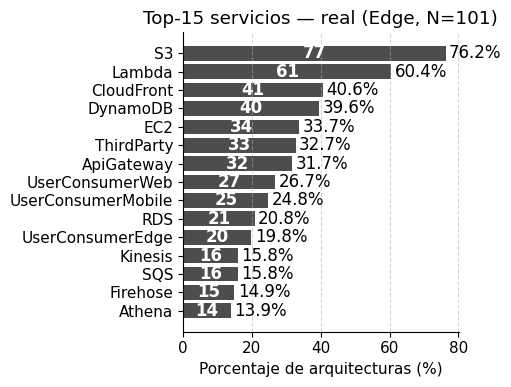

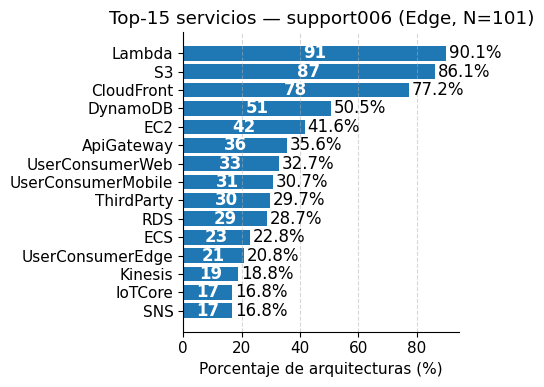

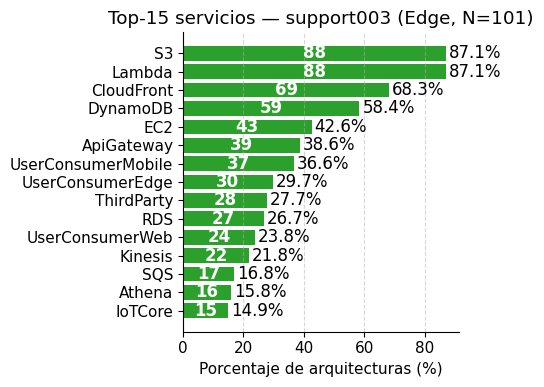

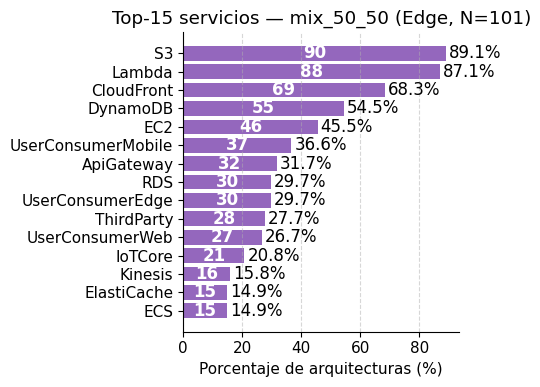

EPS exportados:
- fig_edge_top15_real.eps
- fig_edge_top15_support006.eps
- fig_edge_top15_support003.eps
- fig_edge_top15_mix_50_50.eps


In [ ]:
# ============================================================
# EDGE — Comparative metrics + EPS Figures (Top-15)
# ------------------------------------------------------------
# Outputs:
#   - CSV: edge_gen_101_comparison_summary.csv
#   - EPS: fig_edge_top15_real.eps
#          fig_edge_top15_support006.eps
#          fig_edge_top15_support003.eps
#          fig_edge_top15_mix_50_50.eps
# ============================================================

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

# ---------- 0) Filter real Edge ----------
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].copy()
tx_edge_real = df_edge["services"].tolist()        # 101 real architectures
U_ref_edge   = _service_universe(tx_edge_real)     # reference universe (real Edge)

# ---------- 1) Load (optional) the 3 generated Edge-101 sets ----------
# If you already have them as lists in memory, comment these 3 lines:
gen_edge_006 = pd.read_pickle("edge_gen_support006.pkl")    # list of lists (len=101)
gen_edge_003 = pd.read_pickle("edge_gen_support003.pkl")    # list of lists (len=101)
gen_edge_mix = pd.read_pickle("edge_gen_mix_50_50.pkl")     # list of lists (len=101)

sets = {
    "support_006": gen_edge_006,
    "support_003": gen_edge_003,
    "mix_50_50":   gen_edge_mix
}

# ---------- 2) Comparative metrics (real Edge vs generated) ----------
rows = []
for name, tx_gen in sets.items():
    # Sizes
    real_sizes = _sizes_from_transactions(tx_edge_real)
    gen_sizes  = _sizes_from_transactions(tx_gen)

    # Prevalence and Co-occurrences (evaluation universe = real ∪ generated)
    U_eval = _service_universe(tx_edge_real + tx_gen)
    p_real = _freq_vector(tx_edge_real, U_eval)
    p_gen  = _freq_vector(tx_gen,       U_eval)
    jsd    = float(jensen_shannon(p_real, p_gen, base=np.e))

    C_real = _cooccurrence_matrix(tx_edge_real, U_eval)
    C_gen  = _cooccurrence_matrix(tx_gen,       U_eval)
    frob   = float(frobenius_norm(C_real, C_gen))

    # Local realism (gen → real)
    nn = nn_jaccard_stats(tx_gen, tx_edge_real)

    # Diversity (coverage/entropy w.r.t. the real Edge universe)
    intra = float(intra_jaccard_mean(tx_gen))
    cov   = float(coverage_ratio(tx_gen, U_ref_edge))
    Hn    = float(normalized_entropy(tx_gen, U_ref_edge))

    rows.append({
        "set": name,
        "gen_mean": float(np.mean(gen_sizes)),
        "jsd": jsd, "frob": frob,
        "nn_jacc_mean": nn["mean"],
        "nn_jacc_median": nn["median"],
        "nn_jacc_p95": nn["p95"],
        "intra_jacc_mean": intra,
        "coverage": cov,
        "entropy_norm": Hn,
        "n_gen": len(tx_gen)
    })

# Reference row (to display real set means)
rows.insert(0, {
    "set": "REAL_Edge",
    "gen_mean": float(np.mean(_sizes_from_transactions(tx_edge_real))),
    "jsd": 0.0, "frob": 0.0,
    "nn_jacc_mean": np.nan, "nn_jacc_median": np.nan, "nn_jacc_p95": np.nan,
    "intra_jacc_mean": float(intra_jaccard_mean(tx_edge_real)),
    "coverage": 1.0,
    "entropy_norm": float(normalized_entropy(tx_edge_real, U_ref_edge)),
    "n_gen": len(tx_edge_real)
})

df_edge_summary = pd.DataFrame(rows)
print("=== Comparative summary (Edge: real vs 3 generated) ===")
print(df_edge_summary.round(4).to_string(index=False))
df_edge_summary.round(4).to_csv("edge_gen_101_comparison_summary.csv", index=False)

# ---------- 3) EPS Figures — Top-15 services (Edge) ----------
matplotlib.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 11})

def _top_counts(transactions, top_n=15):
    total = max(1, len(transactions))
    all_services = [s for t in transactions for s in set(t)]
    conteo = Counter(all_services).most_common(top_n)
    df_top = pd.DataFrame(conteo, columns=["Service", "Count"])
    df_top["Percentage"] = (df_top["Count"] / total) * 100
    return df_top, total

def _export_eps(fig, filename):
    fig.savefig(filename, format="eps", bbox_inches="tight")

def plot_top_services_edge(name, transactions, color="#1F77B4", top_n=15):
    df_top, total = _top_counts(transactions, top_n=top_n)
    fig, ax = plt.subplots(figsize=(5.2, 4))
    bars = ax.barh(df_top["Service"], df_top["Percentage"], color=color)

    for bar, pct, n_abs in zip(bars, df_top["Percentage"], df_top["Count"]):
        ax.text(bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{n_abs}",
                ha='center', va='center',
                color='white', fontsize=12, fontweight='semibold')
        ax.text(bar.get_width() + 1,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.1f}%",
                ha='left', va='center', fontsize=12)

    ax.set_title(f"Top-15 services — {name} (Edge, N={total})")
    ax.set_xlabel("Percentage of architectures (%)")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5); ax.yaxis.grid(False)
    ax.invert_yaxis()
    plt.tight_layout()
    _export_eps(fig, f"fig_edge_top15_{name}.eps")
    plt.show()
    plt.close(fig)

# Real + 3 generated (consistent colors)
plot_top_services_edge("real",        tx_edge_real,  color="#4D4D4D")
plot_top_services_edge("support006",  gen_edge_006,  color="#1F77B4")
plot_top_services_edge("support003",  gen_edge_003,  color="#2CA02C")
plot_top_services_edge("mix_50_50",   gen_edge_mix,  color="#9467BD")

print(
    "Exported EPS:\n"
    "- fig_edge_top15_real.eps\n"
    "- fig_edge_top15_support006.eps\n"
    "- fig_edge_top15_support003.eps\n"
    "- fig_edge_top15_mix_50_50.eps"
)


EDGE reales: 101 (esperado ~101)
Archivos generados y guardados:
- edge_gen_support006.pkl/.csv
- edge_gen_support003.pkl/.csv
- edge_gen_mix_50_50.pkl/.csv

Guardado: edge_eval_quick_summary.csv


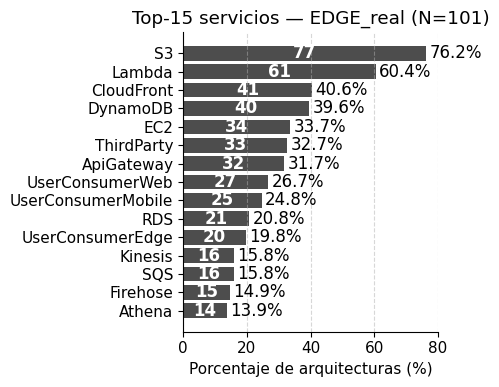

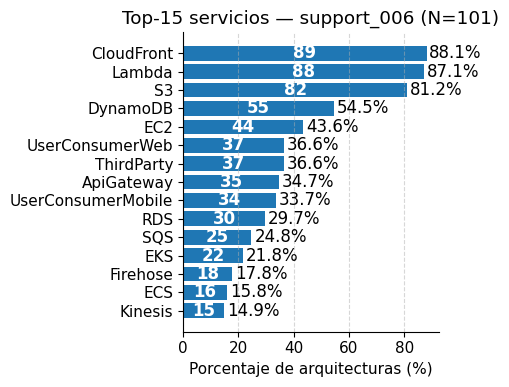

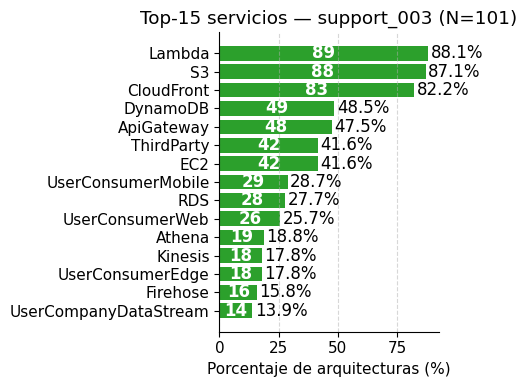

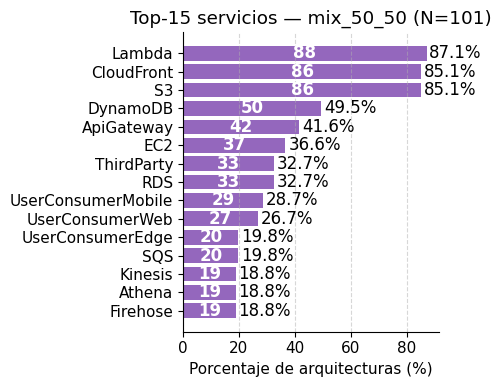


EPS exportados:
- fig_edge_top15_EDGE_real.eps
- fig_edge_top15_support_006.eps
- fig_edge_top15_support_003.eps
- fig_edge_top15_mix_50_50.eps


In [ ]:
# ============================================================
# SINGLE PIPELINE — EDGE: Generation (006/003/mix) + Evaluation + EPS Figures
# ------------------------------------------------------------
# 1) Filter real Edge
# 2) Mine catalogs (0.06, 0.03)
# 3) Generate 3 synthetic sets (N=101): support006, support003, mix 50/50
# 4) Save PKL/CSV for each set
# 5) Evaluate against real Edge with full metrics
# 6) Export 4 EPS figures (Top-15): real, 006, 003, mix
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from scipy.stats import ks_2samp, wasserstein_distance

# ---------- Plot style ----------
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11
})

# ---------- 0) Minimal checks ----------
assert {"services","tipo_arquitectura"}.issubset(df_all.columns), \
    "df_all debe tener columnas ['services','tipo_arquitectura']"

# ---------- 1) Real EDGE ----------
df_edge = df_all[df_all["tipo_arquitectura"]=="Edge"].copy()
N_EDGE  = len(df_edge)
print(f"Real EDGE: {N_EDGE} (expected ~101)")

tx_real = df_edge["services"].tolist()     # list of lists
U_ref   = _service_universe(tx_real)       # universe for coverage/entropy

# ---------- 2) Catalog mining on EDGE ----------
SUPPORTS = (0.06, 0.03)
CONF_MIN = 0.60
LIFT_MIN = 1.05

catalogs_edge = mine_catalogs(
    df_edge["services"].tolist(),
    supports=SUPPORTS, conf_min=CONF_MIN, lift_min=LIFT_MIN
)

# ---------- 3) Generation of 3 sets (N=101) ----------
MAX_SIZE  = 10
N_CANDS   = 100
SEED_BASE = 11000

# Seeds from real EDGE
seeds = select_seeds(df_edge, k=N_EDGE, mix_ratio=0.5, random_state=SEED_BASE)

def _generate_set_edge(cfg_key, seeds, n_archs, rep_seed):
    """cfg_key: '006' or '003' (selects catalog by support)"""
    fis, rules = catalogs_edge[0.06] if cfg_key=='006' else catalogs_edge[0.03]
    out = []
    for i in range(n_archs):
        arch = generate_architecture_size_aware(
            seeds[i], rules, fis, df_edge,
            max_size=MAX_SIZE, n_candidates=N_CANDS,
            require_edge=True,                   # enforce EDGE
            random_state=rep_seed + i
        )
        if arch: out.append(arch)
    return out

gen_edge_006 = _generate_set_edge("006", seeds, N_EDGE, rep_seed=SEED_BASE+1000)
gen_edge_003 = _generate_set_edge("003", seeds, N_EDGE, rep_seed=SEED_BASE+2000)

# Mixed 50/50 interleaving 006 and 003
gen_edge_mix = [(gen_edge_006[i] if i%2==0 else gen_edge_003[i]) for i in range(min(len(gen_edge_006),len(gen_edge_003)))]

# ---------- 4) Save PKL/CSV ----------
pd.to_pickle(gen_edge_006, "edge_gen_support006.pkl")
pd.DataFrame({"services": gen_edge_006}).to_csv("edge_gen_support006.csv", index=False)

pd.to_pickle(gen_edge_003, "edge_gen_support003.pkl")
pd.DataFrame({"services": gen_edge_003}).to_csv("edge_gen_support003.csv", index=False)

pd.to_pickle(gen_edge_mix, "edge_gen_mix_50_50.pkl")
pd.DataFrame({"services": gen_edge_mix}).to_csv("edge_gen_mix_50_50.csv", index=False)

print("Files generated and saved:")
print("- edge_gen_support006.pkl/.csv")
print("- edge_gen_support003.pkl/.csv")
print("- edge_gen_mix_50_50.pkl/.csv")

# ---------- 5) Full evaluation (real vs 3 generated) ----------
def _top_counts(transactions, top_n=15):
    total = max(1, len(transactions))
    all_services = [s for t in transactions for s in set(t)]
    conteo = Counter(all_services).most_common(top_n)
    df_top = pd.DataFrame(conteo, columns=["Service","Count"])
    df_top["Percentage"] = (df_top["Count"] / total) * 100
    return df_top, total

def _export_eps(fig, filename):
    fig.savefig(filename, format="eps", bbox_inches="tight")

def plot_top_services(name, transactions, color, top_n=15):
    df_top, total = _top_counts(transactions, top_n=top_n)
    fig, ax = plt.subplots(figsize=(5,4))
    bars = ax.barh(df_top["Service"], df_top["Percentage"], color=color)
    for bar, pct, n_abs in zip(bars, df_top["Percentage"], df_top["Count"]):
        ax.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2,
                f"{n_abs}", ha='center', va='center', color='white',
                fontsize=12, fontweight='semibold')
        ax.text(bar.get_width()+1, bar.get_y()+bar.get_height()/2,
                f"{pct:.1f}%", ha='left', va='center', fontsize=12)
    ax.set_title(f"Top-15 services — {name} (N={total})")
    ax.set_xlabel("Percentage of architectures (%)")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5); ax.yaxis.grid(False)
    ax.invert_yaxis()
    plt.tight_layout(); _export_eps(fig, f"fig_edge_top15_{name}.eps"); plt.show(); plt.close(fig)

def eval_set(name, tx_gen, catalogs_for_rules, universe_ref):
    # Sizes
    real_sizes = _sizes_from_transactions(tx_real)
    gen_sizes  = _sizes_from_transactions(tx_gen)
    ks = ks_2samp(real_sizes, gen_sizes, alternative="two-sided", mode="auto")
    wd = wasserstein_distance(real_sizes, gen_sizes)

    # Universe for JSD/Frobenius (real ∪ generated)
    U_eval = _service_universe(tx_real + tx_gen)
    p_real = _freq_vector(tx_real, U_eval)
    p_gen  = _freq_vector(tx_gen,  U_eval)
    jsd    = jensen_shannon(p_real, p_gen, base=np.e)

    C_real = _cooccurrence_matrix(tx_real, U_eval)
    C_gen  = _cooccurrence_matrix(tx_gen,  U_eval)
    frob   = frobenius_norm(C_real, C_gen)

    # Rules (catalog consistent with the set)
    if name == "support_006":
        _, rules_df = catalogs_for_rules[0.06]
        d = rules_delta_confidence(rules_df, tx_real, tx_gen, top_k=50)
    elif name == "support_003":
        _, rules_df = catalogs_for_rules[0.03]
        d = rules_delta_confidence(rules_df, tx_real, tx_gen, top_k=50)
    else:  # mixed: average both catalogs
        _, r006 = catalogs_for_rules[0.06]
        _, r003 = catalogs_for_rules[0.03]
        d1 = rules_delta_confidence(r006, tx_real, tx_gen, top_k=50)
        d2 = rules_delta_confidence(r003, tx_real, tx_gen, top_k=50)
        d = {
            "delta_mean":   np.nanmean([d1["delta_mean"],   d2["delta_mean"]]),
            "delta_median": np.nanmean([d1["delta_median"], d2["delta_median"]]),
            "delta_p95":    np.nanmean([d1["delta_p95"],    d2["delta_p95"]]),
            "n_eval":       int((d1["n_eval"] or 0) + (d2["n_eval"] or 0)) // 2
        }

    # Local realism (NN-Jaccard) and diversity
    nn  = nn_jaccard_stats(tx_gen, tx_real)
    intra = intra_jaccard_mean(tx_gen)
    cov   = coverage_ratio(tx_gen, universe_ref)
    Hn    = normalized_entropy(tx_gen, universe_ref)

    return {
        "set": name,
        "gen_mean": float(np.mean(gen_sizes)),
        "jsd": float(jsd),
        "frob": float(frob),
        "nn_jacc_mean": nn["mean"],
        "nn_jacc_median": nn["median"],
        "nn_jacc_p95": nn["p95"],
        "intra_jacc_mean": intra,
        "coverage": cov,
        "entropy_norm": Hn,
        "rules_delta_mean": d["delta_mean"],
        "rules_delta_median": d["delta_median"],
        "rules_delta_p95": d["delta_p95"],
        "n_gen": len(tx_gen)
    }

# Evaluate the three sets
summary_rows = []
summary_rows.append(eval_set("support_003", gen_edge_003, catalogs_edge, U_ref))
summary_rows.append(eval_set("support_006", gen_edge_006, catalogs_edge, U_ref))
summary_rows.append(eval_set("mix_50_50",   gen_edge_mix, catalogs_edge, U_ref))

df_summary = pd.DataFrame(summary_rows).set_index("set").round(4)
#print("\n=== Comparative summary (Edge: real vs 3 generated) ===")
#print(df_summary.to_string())

# Save summary
df_summary.to_csv("edge_eval_quick_summary.csv")
print("\nSaved: edge_eval_quick_summary.csv")

# ---------- 6) EPS Figures (Top-15) ----------
plot_top_services("EDGE_real",   tx_real,        color="#4D4D4D")

plot_top_services("support_006", gen_edge_006,   color="#1F77B4")

plot_top_services("support_003", gen_edge_003,   color="#2CA02C")

plot_top_services("mix_50_50",   gen_edge_mix,   color="#9467BD")

print("\nExported EPS:")
print("- fig_edge_top15_EDGE_real.eps")
print("- fig_edge_top15_support_006.eps")
print("- fig_edge_top15_support_003.eps")
print("- fig_edge_top15_mix_50_50.eps")


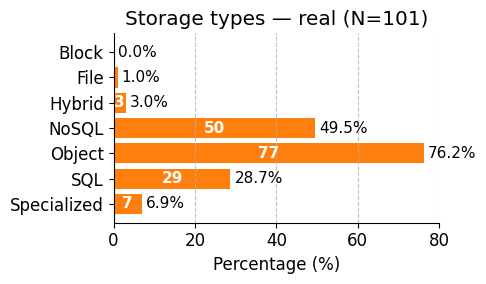

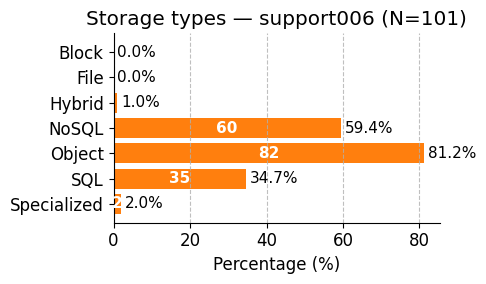

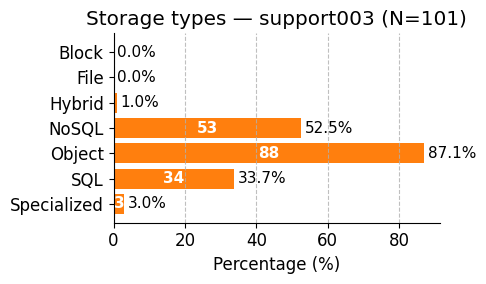

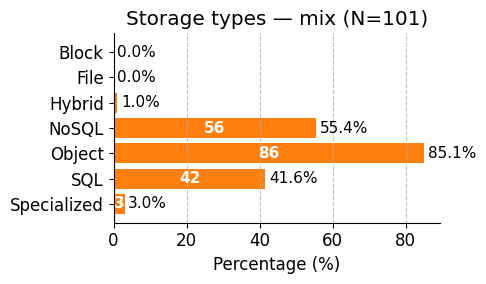

Listo (EDGE):
- EPS: edge_fig_storage_{real|support006|support003|mix}.eps
- CSV: edge_storage_{set}.csv
- CSV consolidado: edge_storage_all_sets.csv


In [ ]:
# ============================================================
# EDGE — Storage comparison: real vs 3 generated sets
# Outputs:
#   EPS:  edge_fig_storage_{real|support006|support003|mix}.eps
#   CSV:  edge_storage_{set}.csv  and  edge_storage_all_sets.csv
# Requires:
#   - df_all[['services','tipo_arquitectura']] already loaded
#   - gen_edge_006, gen_edge_003, gen_edge_mix (lists of 101 architectures)
#     (if not in memory, uncomment the 3 read_pickle lines)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter

# ---------- (Optional) load the 3 generated Edge sets ----------
# gen_edge_006 = pd.read_pickle("edge_gen_support006.pkl")
# gen_edge_003 = pd.read_pickle("edge_gen_support003.pkl")
# gen_edge_mix = pd.read_pickle("edge_gen_mix_50_50.pkl")

# ---------- Real Edge ----------
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].copy()
tx_edge_real = df_edge["services"].tolist()   # list of 101 lists

# ---------- Ensure the 3 generated lists are in memory ----------
SETS = {
    "real":        tx_edge_real,
    "support006":  gen_edge_006,
    "support003":  gen_edge_003,
    "mix":         gen_edge_mix,     # 50/50 of 0.06 and 0.03 catalogs
}

# ---------- Figure style ----------
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12
})

# ---------- Storage taxonomy (case-insensitive) ----------
storage_taxonomy = {
    # Object
    "S3": "Object", "MediaStore": "Object",
    # File
    "EFS": "File", "FSX": "File", "FSx": "File",
    # SQL
    "RDS": "SQL", "Aurora": "SQL",
    # NoSQL / Cache
    "DynamoDB": "NoSQL", "DocumentDB": "NoSQL", "MemoryDB": "NoSQL", "ElastiCache": "NoSQL",
    # Specialized
    "RedShift": "Specialized", "Redshift": "Specialized", "Neptune": "Specialized", "Timestream": "Specialized",
    # Block / Hybrid
    "EBS": "Block", "StorageGateway": "Hybrid",
}
TAX = {k.strip().lower(): v for k, v in storage_taxonomy.items()}

# Y-axis order (consistent with your examples)
ORDER = ["Specialized", "SQL", "Object", "NoSQL", "Hybrid", "File", "Block"]

def storage_summary(transactions):
    """
    Counts, per architecture, the presence (>=1) of each storage type.
    Returns:
      - df_counts: counts by type
      - df_pct:    percentages by type (% of architectures including it)
      - total:     number of architectures in the set
    """
    total = max(1, len(transactions))
    counts = Counter({t: 0 for t in ORDER})
    for arch in transactions:
        tipos_presentes = set()
        for s in set(str(x).strip().lower() for x in arch):
            if s in TAX:
                tipos_presentes.add(TAX[s])
        for t in tipos_presentes:
            counts[t] += 1
    df_counts = pd.Series(counts).loc[ORDER].rename("count").to_frame()
    df_pct = (df_counts["count"] / total * 100.0).round(1).rename("pct").to_frame()
    return df_counts, df_pct, total

def plot_storage_eps(name, df_counts, df_pct, total, color="#FF7F0E"):
    tipos = df_pct.index.tolist()
    valores = df_pct["pct"].tolist()

    fig, ax = plt.subplots(figsize=(5, 3))
    bars = ax.barh(tipos, valores, color=color)

    for bar, tipo, pct in zip(bars, tipos, valores):
        n_abs = int(df_counts.loc[tipo, "count"])
        y = bar.get_y() + bar.get_height()/2
        # absolute count inside the bar (if width allows)
        if bar.get_width() > 1:
            ax.text(bar.get_width()*0.5, y, f"{n_abs}",
                    ha="center", va="center", color="white",
                    fontsize=11, fontweight="semibold")
        # percentage to the right
        ax.text(bar.get_width()+1, y, f"{pct:.1f}%",
                ha="left", va="center", fontsize=11)

    ax.set_xlabel("Percentage (%)")
    ax.set_title(f"Storage types — {name} (N={total})")
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.8); ax.yaxis.grid(False)
    plt.tight_layout()
    fig.savefig(f"edge_fig_storage_{name}.eps", format="eps", bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ---------- Run for each set and save CSV ----------
rows_all = []
for name, tx in SETS.items():
    df_counts, df_pct, N = storage_summary(tx)

    # CSV per set (counts + percentages)
    out = pd.concat([df_counts.T, df_pct.T], axis=0)
    out.index = ["count", "pct"]
    out.to_csv(f"edge_storage_{name}.csv")

    # EPS figure
    plot_storage_eps(name, df_counts, df_pct, N, color="#FF7F0E")

    # Consolidated row
    rec = {"set": name, "N": N}
    for t in ORDER:
        rec[f"{t}_count"] = int(df_counts.loc[t, "count"])
        rec[f"{t}_pct"]   = float(df_pct.loc[t, "pct"])
    rows_all.append(rec)

# Consolidated CSV
df_all_sets = pd.DataFrame(rows_all).set_index("set")
df_all_sets.to_csv("edge_storage_all_sets.csv")

print("Done (EDGE):")
print("- EPS: edge_fig_storage_{real|support006|support003|mix}.eps")
print("- CSV: edge_storage_{set}.csv")
print("- Consolidated CSV: edge_storage_all_sets.csv")


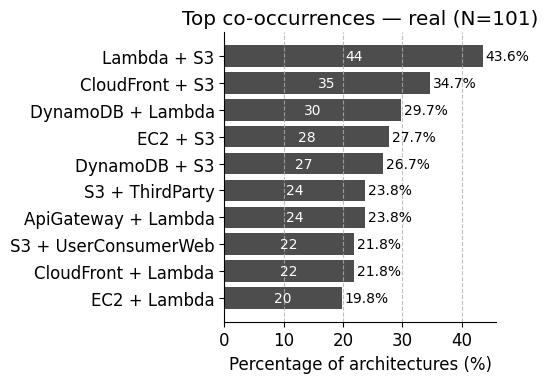

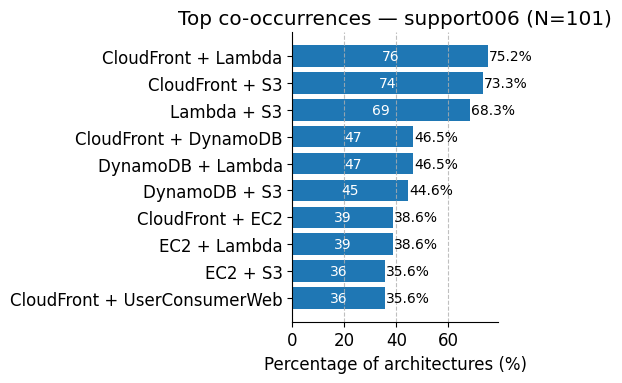

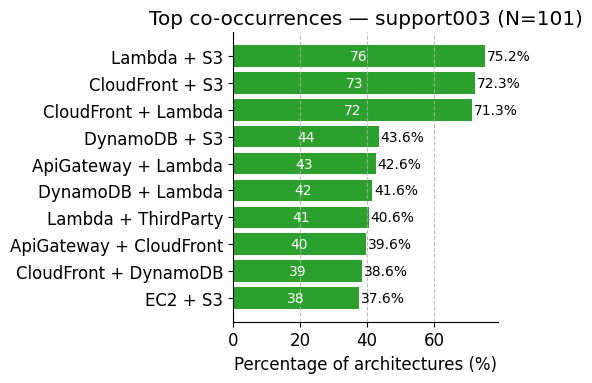

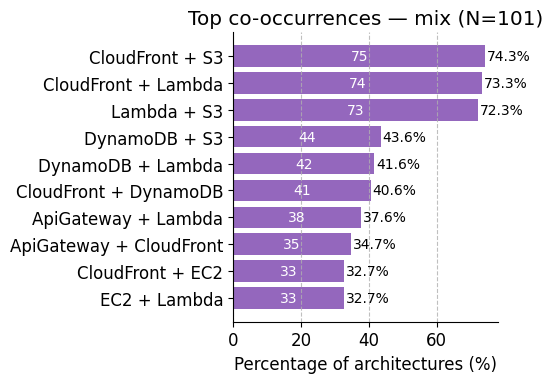

Listo:
- EPS:  edge_cooc_{real|support006|support003|mix}.eps
- CSV:  edge_cooc_{real|support006|support003|mix}.csv


In [ ]:
# ============================================================
# EDGE — Top-N co-occurrences: real vs generated (0.06, 0.03, mix)
# Outputs:
#   EPS: edge_cooc_{real|support006|support003|mix}.eps
#   CSV: edge_cooc_{real|support006|support003|mix}.csv
# Requires:
#   - df_all[['services','tipo_arquitectura']]
#   - gen_edge_006, gen_edge_003, gen_edge_mix  (lists of 101 architectures)
#     (if not in memory, uncomment the 3 read_pickle lines)
# ============================================================

from collections import Counter
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# --- (Optional) load generated sets ---
# gen_edge_006 = pd.read_pickle("edge_gen_support006.pkl")
# gen_edge_003 = pd.read_pickle("edge_gen_support003.pkl")
# gen_edge_mix = pd.read_pickle("edge_gen_mix_50_50.pkl")

# --- Real (Edge) ---
df_edge = df_all[df_all["tipo_arquitectura"] == "Edge"].copy()
tx_real = df_edge["services"].tolist()     # list of 101 lists

SETS = {
    "real":        tx_real,
    "support006":  gen_edge_006,
    "support003":  gen_edge_003,
    "mix":         gen_edge_mix,
}

# --- Figure style (same as example) ---
matplotlib.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12
})

def top_coocurrences(transactions, top_n=10):
    """
    Returns a DataFrame with columns:
      - pair: tuple (A,B) ordered alphabetically
      - count: # of architectures where A and B co-occur
      - pct:   count / N * 100
    """
    N = max(1, len(transactions))
    cooc = Counter()
    for services in transactions:
        u = sorted(set(services))
        for a, b in combinations(u, 2):
            cooc[(a, b)] += 1
    df = pd.DataFrame(
        [(pair, c, 100.0 * c / N) for pair, c in cooc.items() ],
        columns=["pair", "count", "pct"]
    ).sort_values("pct", ascending=False).head(top_n)
    return df, N

def plot_cooc_eps(name, df_pairs, N, color="#1F77B4"):
    labels = [f"{a} + {b}" for (a, b) in df_pairs["pair"]]
    pct    = df_pairs["pct"].values
    cnt    = df_pairs["count"].values

    fig, ax = plt.subplots(figsize=(5.5, 4))
    bars = ax.barh(labels, pct, color=color)

    # percentage to the right + (optional) centered count
    for bar, p, n in zip(bars, pct, cnt):
        ax.text(bar.get_width() + 0.5,
                bar.get_y() + bar.get_height()/2,
                f"{p:.1f}%",
                va='center', fontsize=10)
        if bar.get_width() > 5:
            ax.text(bar.get_width()/2,
                    bar.get_y() + bar.get_height()/2,
                    f"{n}",
                    ha='center', va='center', color='white', fontsize=10)

    ax.set_xlabel("Percentage of architectures (%)")
    ax.set_title(f"Top co-occurrences — {name} (N={N})")
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True); ax.spines['bottom'].set_visible(True)
    ax.xaxis.grid(True, linestyle='--', alpha=0.8); ax.yaxis.grid(False)
    plt.tight_layout()
    fig.savefig(f"edge_cooc_{name}.eps", format="eps", bbox_inches="tight")
    plt.show()
    plt.close(fig)

# --- Run for the 4 sets and save CSV + EPS ---
for name, tx in SETS.items():
    df_pairs, N = top_coocurrences(tx, top_n=10)
    df_pairs.to_csv(f"edge_cooc_{name}.csv", index=False)   # pair,count,pct
    plot_cooc_eps(name, df_pairs, N,
                  color={"real":"#4D4D4D","support006":"#1F77B4","support003":"#2CA02C","mix":"#9467BD"}[name])

print("Done:")
print("- EPS:  edge_cooc_{real|support006|support003|mix}.eps")
print("- CSV:  edge_cooc_{real|support006|support003|mix}.csv")


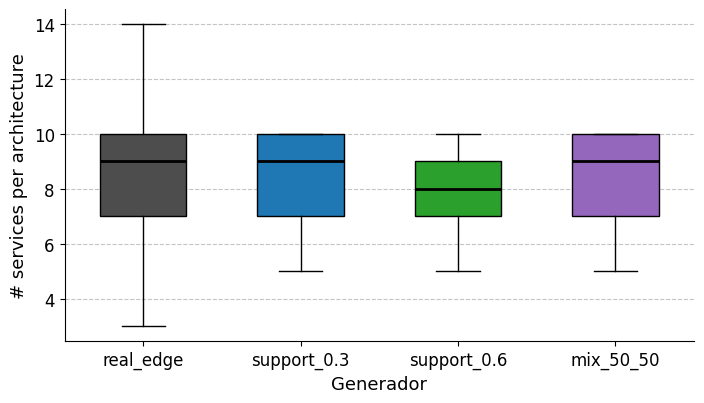


Resumen (número de servicios por arquitectura):
             mean  median  min   max   std
real_edge    8.50     9.0  3.0  14.0  2.13
support_0.3  8.35     9.0  5.0  10.0  1.53
support_0.6  8.27     8.0  5.0  10.0  1.38
mix_50_50    8.44     9.0  5.0  10.0  1.47


In [ ]:
# ============================
# Boxplot and statistics: real EDGE vs 3 generators
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12
})

# ---------- 1) Sets ----------
# Real EDGE from the original dataframe
tx_edge_real = df_all.loc[df_all["tipo_arquitectura"]=="Edge", "services"].tolist()

# Make sure these three are in memory (lists of 101 transactions)
# gen_edge_003, gen_edge_006, gen_edge_mix

# ---------- 2) Utility: sizes per architecture ----------
def sizes_from_tx(tx):
    """Number of distinct services per architecture."""
    return [len(set(t)) for t in tx]

sizes_real = sizes_from_tx(tx_edge_real)
sizes_003  = sizes_from_tx(gen_edge_003)
sizes_006  = sizes_from_tx(gen_edge_006)
sizes_mix  = sizes_from_tx(gen_edge_mix)

# Wide DataFrame for stats and for the boxplot
df_servicios_gen = pd.DataFrame({
    "real_edge":  pd.Series(sizes_real),
    "support_0.3":pd.Series(sizes_003),
    "support_0.6":pd.Series(sizes_006),
    "mix_50_50":  pd.Series(sizes_mix),
})

# ---------- 3) Boxplot (4 groups) ----------
ORDER = ["real_edge", "support_0.3", "support_0.6", "mix_50_50"]
COLOR_GEN = {
    "real_edge":  "#4D4D4D",   # gray
    "support_0.3":"#1F77B4",   # blue
    "support_0.6":"#2CA02C",   # green
    "mix_50_50":  "#9467BD",   # purple
}

fig, ax = plt.subplots(figsize=(7.2, 4.2))
bp = ax.boxplot(
    [df_servicios_gen[col].dropna() for col in ORDER],
    patch_artist=True,
    labels=ORDER,
    widths=0.55,
    showfliers=True
)

# Colors, borders, and style
for patch, name in zip(bp["boxes"], ORDER):
    patch.set_facecolor(COLOR_GEN[name])
    patch.set_edgecolor("black"); patch.set_linewidth(1)

plt.setp(bp["medians"], color="black", linewidth=2)
plt.setp(bp["whiskers"], color="black", linewidth=1)
plt.setp(bp["caps"], color="black", linewidth=1)
plt.setp(bp["fliers"], marker="o", color="black", alpha=0.4, markersize=4)

ax.set_xlabel("Generator", fontsize=13)
ax.set_ylabel("# services per architecture", fontsize=13)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.75)
ax.xaxis.grid(False)

plt.tight_layout()
fig.savefig("fig_boxplot_edge_real_vs_generadores.eps", format="eps", bbox_inches="tight")
plt.show(); plt.close(fig)

# ---------- 4) Statistics table ----------
# (Fixes the TypeError by using a list of functions in agg)
estadisticas_gen = df_servicios_gen[ORDER].agg(["mean", "median", "min", "max", "std"]).T
estadisticas_gen = estadisticas_gen.rename(columns={
    "mean":"mean", "median":"median", "min":"min", "max":"max", "std":"std"
}).round(2)

print("\nSummary (number of services per architecture):")
print(estadisticas_gen)

# Save CSV for appendix/paper
estadisticas_gen.to_csv("stats_edge_real_vs_generadores.csv")


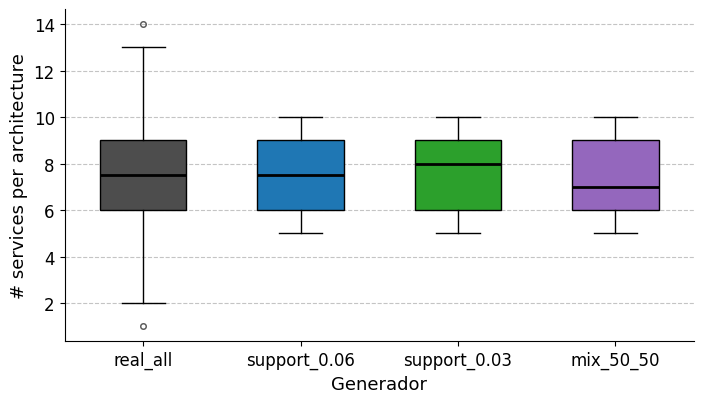


Resumen (número de servicios por arquitectura — GENERAL):
              mean  median  min   max   std
real_all      7.45     7.5  1.0  14.0  2.17
support_0.06  7.58     7.5  5.0  10.0  1.64
support_0.03  7.69     8.0  5.0  10.0  1.61
mix_50_50     7.57     7.0  5.0  10.0  1.60


In [ ]:
# ============================================
# Boxplot and statistics — GENERAL architectures
# Real (396) vs support_0.06 / support_0.03 / ensemble
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 12
})

# ---------- (Optional) load generated sets if not in memory ----------
# gen_006      = pd.read_pickle("gen_396_support006.pkl")          # list of lists (396)
# gen_003      = pd.read_pickle("gen_396_support003.pkl")          # list of lists (396)
# gen_ensemble = pd.read_pickle("gen_396_ensemble_006_003.pkl")    # list of lists (396)

# ---------- 1) Sets ----------
tx_real_all = df_all["services"].tolist()  # All 396 real architectures

def sizes_from_tx(tx):
    """Number of distinct services per architecture."""
    return [len(set(t)) for t in tx]

sizes_real = sizes_from_tx(tx_real_all)
sizes_006  = sizes_from_tx(gen_006)
sizes_003  = sizes_from_tx(gen_003)
sizes_mix  = sizes_from_tx(gen_ensemble)

# Wide DataFrame for stats and boxplot
df_servicios_gen = pd.DataFrame({
    "real_all":     pd.Series(sizes_real),
    "support_0.06": pd.Series(sizes_006),
    "support_0.03": pd.Series(sizes_003),
    "mix_50_50":    pd.Series(sizes_mix),
})

# ---------- 2) Boxplot ----------
ORDER = ["real_all", "support_0.06", "support_0.03", "mix_50_50"]
COLOR_GEN = {
    "real_all":     "#4D4D4D",  # gray
    "support_0.06": "#1F77B4",  # blue
    "support_0.03": "#2CA02C",  # green
    "mix_50_50":    "#9467BD",  # purple
}

fig, ax = plt.subplots(figsize=(7.2, 4.2))
bp = ax.boxplot(
    [df_servicios_gen[col].dropna() for col in ORDER],
    patch_artist=True,
    labels=ORDER,
    widths=0.55,
    showfliers=True
)

for patch, name in zip(bp["boxes"], ORDER):
    patch.set_facecolor(COLOR_GEN[name])
    patch.set_edgecolor("black"); patch.set_linewidth(1)

plt.setp(bp["medians"], color="black", linewidth=2)
plt.setp(bp["whiskers"], color="black", linewidth=1)
plt.setp(bp["caps"], color="black", linewidth=1)
plt.setp(bp["fliers"], marker="o", color="black", alpha=0.4, markersize=4)

ax.set_xlabel("Generator", fontsize=13)
ax.set_ylabel("# services per architecture", fontsize=13)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.75)
ax.xaxis.grid(False)

plt.tight_layout()
fig.savefig("fig_boxplot_general_real_vs_generadores.eps", format="eps", bbox_inches="tight")
plt.show(); plt.close(fig)

# ---------- 3) Statistics table ----------
stats_general = df_servicios_gen[ORDER].agg(["mean","median","min","max","std"]).T.round(2)
print("\nSummary (number of services per architecture — GENERAL):")
print(stats_general)

stats_general.to_csv("stats_general_real_vs_generadores.csv")
